In [ ]:
import json

# Check if data file exists and what's in it
with open('parameter_sweep_data.json', 'r') as f:
    data = json.load(f)

print("Keys in data:", list(data.keys()))
if 'data' in data:
    print(f"Number of runs: {len(data['data'])}")
    if len(data['data']) > 0:
        print("First run keys:", list(data['data'][0].keys()))
        print("Available timesteps:", sorted(set(r['timestep'] for r in data['data'])))
    else:
        print("Data array is empty - need to run data collection!")
else:
    print("Data structure:", data)

Keys in data: ['metadata', 'data']
Number of runs: 25
First run keys: ['alpha', 'timestep', 'n_layers', 'converged', 'steps_to_converge', 'physical_time_to_converge', 'max_dT_final', 'max_grad_diff_final', 'n_convective_initial', 'n_adiabatic_initial', 'n_radiative_initial', 'n_convective_final', 'n_adiabatic_final', 'n_radiative_final', 'convective_locations_initial', 'adiabatic_locations_initial', 'radiative_locations_initial', 'convective_locations_final', 'adiabatic_locations_final', 'radiative_locations_final', 'convective_altitudes_initial', 'adiabatic_altitudes_initial', 'radiative_altitudes_initial', 'convective_altitudes_final', 'adiabatic_altitudes_final', 'radiative_altitudes_final', 'z_interfaces', 'z_interfaces_km', 'T_initial', 'T_final', 'P_initial', 'P_final', 'z_centers', 'z_centers_km', 'N_initial', 'N_final', 'N_ad', 'adiabaticity_initial', 'adiabaticity_final', 'adiabaticity_final_convective', 'layer_type_initial', 'layer_type_final', 'F_conv_final', 'rho_final', 'r

In [2]:
import json
import numpy as np
import matplotlib.pyplot as plt

def plot_convergence_vs_mixing_length(data_file='parameter_sweep_data.json', timestep=100):
    """
    Plot steps to converge vs mixing length (alpha) for a given timestep.
    
    Args:
        data_file: Path to parameter sweep data JSON file
        timestep: Timestep value to filter by (seconds)
    """
    # Load data
    with open(data_file, 'r') as f:
        data = json.load(f)
    
    # Filter data for the specified timestep
    runs_at_timestep = [run for run in data['data'] if abs(run['timestep'] - timestep) < 1e-6]
    
    if len(runs_at_timestep) == 0:
        print(f"Error: No runs found with timestep = {timestep} s")
        print(f"Available timesteps: {sorted(set(r['timestep'] for r in data['data']))}")
        return
    
    # Extract alpha and steps_to_converge
    alphas = [run['alpha'] for run in runs_at_timestep]
    steps = [run['steps_to_converge'] for run in runs_at_timestep]
    physical_time = [run['physical_time_to_converge'] / 3600.0 for run in runs_at_timestep]  # hours
    converged = [run['converged'] for run in runs_at_timestep]
    
    # Sort by alpha for clean plotting
    sort_idx = np.argsort(alphas)
    alphas = np.array(alphas)[sort_idx]
    steps = np.array(steps)[sort_idx]
    physical_time = np.array(physical_time)[sort_idx]
    converged = np.array(converged)[sort_idx]
    
    # Create figure with subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
    
    # Plot 1: Steps to converge vs alpha
    not_converged_mask = ~np.array(converged)
    
    # Plot converged runs as scatter points only (no lines)
    converged_mask = np.array(converged)
    if np.any(converged_mask):
        ax1.scatter(alphas[converged_mask], steps[converged_mask], 
                   marker='o', s=100, color='steelblue', label='Converged', zorder=10)
    
    # Mark non-converged runs differently
    if np.any(not_converged_mask):
        ax1.scatter(alphas[not_converged_mask], steps[not_converged_mask], 
                   marker='x', s=200, color='red', linewidths=3, label='Not converged', zorder=10)
    
    ax1.set_xlabel('Mixing Length Parameter (α)', fontsize=12, fontweight='bold')
    ax1.set_ylabel('Steps to Converge', fontsize=12, fontweight='bold')
    ax1.set_title(f'Steps to Converge vs Mixing Length\nTimestep = {timestep} s', 
                 fontsize=13, fontweight='bold')
    ax1.set_xscale('log')
    ax1.set_yscale('log')
    ax1.grid(True, alpha=0.3, linestyle='--')
    ax1.legend(fontsize=10)
    
    # Add annotations for alpha values
    for i, (alpha, step) in enumerate(zip(alphas, steps)):
        if i % 2 == 0 or len(alphas) <= 5:
            ax1.annotate(f'α={alpha:.2f}', (alpha, step), 
                        textcoords="offset points", xytext=(0,10), 
                        ha='center', fontsize=9, alpha=0.7)
    
    # Plot 2: Physical time to converge vs alpha
    converged_mask = np.array(converged)
    if np.any(converged_mask):
        ax2.scatter(alphas[converged_mask], physical_time[converged_mask], 
                   marker='s', s=100, color='darkgreen', label='Converged', zorder=10)
    
    if np.any(not_converged_mask):
        ax2.scatter(alphas[not_converged_mask], physical_time[not_converged_mask], 
                   marker='x', s=200, color='red', linewidths=3, label='Not converged', zorder=10)
    
    ax2.set_xlabel('Mixing Length Parameter (α)', fontsize=12, fontweight='bold')
    ax2.set_ylabel('Physical Time to Converge (hours)', fontsize=12, fontweight='bold')
    ax2.set_title(f'Physical Time vs Mixing Length\nTimestep = {timestep} s', 
                 fontsize=13, fontweight='bold')
    ax2.set_xscale('log')
    ax2.set_yscale('log')
    ax2.grid(True, alpha=0.3, linestyle='--')
    ax2.legend(fontsize=10)
    
    # Add annotations
    for i, (alpha, time) in enumerate(zip(alphas, physical_time)):
        if i % 2 == 0 or len(alphas) <= 5:
            ax2.annotate(f'{time:.2f}h', (alpha, time), 
                        textcoords="offset points", xytext=(0,10), 
                        ha='center', fontsize=9, alpha=0.7)
    
    plt.tight_layout()
    plt.show()
    
    # Print summary statistics
    print(f"\nSummary for timestep = {timestep} s:")
    print(f"  Total runs: {len(runs_at_timestep)}")
    print(f"  Converged: {np.sum(converged)}")
    print(f"  Not converged: {np.sum(~converged)}")
    print(f"  Alpha range: [{min(alphas):.3f}, {max(alphas):.3f}]")
    if np.any(converged):
        converged_steps = steps[converged]
        print(f"  Steps range (converged): [{min(converged_steps):.0f}, {max(converged_steps):.0f}]")
        converged_time = physical_time[converged]
        print(f"  Time range (converged): [{min(converged_time):.2f}, {max(converged_time):.2f}] hours")

# Example usage:
# plot_convergence_vs_mixing_length(timestep=10)
# plot_convergence_vs_mixing_length(timestep=100)

In [3]:
import json
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

def plot_temperature_heatmap(data_file='parameter_sweep_data.json', alpha=None, timestep=None):
    """
    Plot temperature profile before/after as a heatmap with colorbar.
    
    Args:
        data_file: Path to parameter sweep data JSON file
        alpha: Mixing length parameter to filter by (optional)
        timestep: Timestep to filter by (optional, in seconds)
    
    If both are None, plots all runs. If one is specified, filters by that parameter.
    """
    # Load data
    with open(data_file, 'r') as f:
        data = json.load(f)
    
    # Filter data based on parameters
    filtered_runs = data['data']
    
    if alpha is not None:
        filtered_runs = [run for run in filtered_runs if abs(run['alpha'] - alpha) < 1e-6]
    
    if timestep is not None:
        filtered_runs = [run for run in filtered_runs if abs(run['timestep'] - timestep) < 1e-6]
    
    if len(filtered_runs) == 0:
        print(f"No runs found matching alpha={alpha}, timestep={timestep}")
        return
    
    print(f"Plotting {len(filtered_runs)} run(s)")
    
    # Create figure - one subplot per run
    n_runs = len(filtered_runs)
    n_cols = min(3, n_runs)  # Max 3 columns
    n_rows = int(np.ceil(n_runs / n_cols))
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(6*n_cols, 8*n_rows))
    if n_runs == 1:
        axes = np.array([axes])
    axes = axes.flatten()
    
    # Find global temperature range for consistent colorbar
    # Filter out invalid values (NaN, Inf, or unreasonable values)
    all_T_initial = []
    all_T_final = []
    for run in filtered_runs:
        T_init = np.array(run['T_initial'])
        T_fin = np.array(run['T_final'])
        
        # Filter out NaN, Inf, and unreasonable values
        # Use more aggressive filter: reasonable atmospheric temps are 100-3000K
        valid_init = T_init[(~np.isnan(T_init)) & (~np.isinf(T_init)) & (T_init > 0) & (T_init < 3000)]
        valid_fin = T_fin[(~np.isnan(T_fin)) & (~np.isinf(T_fin)) & (T_fin > 0) & (T_fin < 3000)]
        
        all_T_initial.extend(valid_init.tolist())
        all_T_final.extend(valid_fin.tolist())
    
    if len(all_T_initial) == 0 or len(all_T_final) == 0:
        print(f"ERROR: No valid temperature data found in filtered runs!")
        print(f"Filtered runs count: {len(filtered_runs)}")
        return
    
    # Use percentiles to filter outliers (more robust than min/max)
    all_T_combined = all_T_initial + all_T_final
    if len(all_T_combined) > 0:
        # Use 5th and 95th percentiles to filter extreme outliers
        p5 = np.percentile(all_T_combined, 5)
        p95 = np.percentile(all_T_combined, 95)
        
        # Further filter to reasonable range
        filtered_T = [t for t in all_T_combined if p5 <= t <= p95]
        
        if len(filtered_T) > 0:
            vmin_raw = min(filtered_T)
            vmax_raw = max(filtered_T)
        else:
            # Fallback to percentile values
            vmin_raw = p5
            vmax_raw = p95
    else:
        # Fallback
        vmin_raw = 500
        vmax_raw = 2000
    
    # Additional sanity check - cap at reasonable atmospheric values
    vmin_raw = max(0, vmin_raw)
    vmax_raw = min(3000, vmax_raw)
    
    if vmax_raw < vmin_raw or vmin_raw < 0 or vmax_raw > 3000:
        print(f"WARNING: Suspicious temperature range: [{vmin_raw:.1f}, {vmax_raw:.1f}] K")
        print(f"Falling back to default range...")
        vmin_raw = 500
        vmax_raw = 2000
    
    # Set colorbar range with -200K / +200K padding
    vmin = max(0, vmin_raw - 200)
    vmax = vmax_raw + 200
    
    print(f"Temperature range (data, filtered): [{vmin_raw:.1f}, {vmax_raw:.1f}] K")
    print(f"Colorbar range: [{vmin:.1f}, {vmax:.1f}] K")
    
    for idx, run in enumerate(filtered_runs):
        ax = axes[idx]
        
        # Extract data
        z_interfaces = np.array(run['z_interfaces_km'])  # km
        T_initial = np.array(run['T_initial'])  # K
        T_final = np.array(run['T_final'])  # K
        layer_type_final = run['layer_type_final']  # List of layer types
        
        # Check for NaN values - indicates non-convergence or error
        nan_initial = np.sum(np.isnan(T_initial))
        nan_final = np.sum(np.isnan(T_final))
        inf_initial = np.sum(np.isinf(T_initial))
        inf_final = np.sum(np.isinf(T_final))
        
        has_nan = (nan_final > 0) or (inf_final > 0)  # NaN in final state indicates non-convergence
        
        if has_nan:
            # Mark as not converged if not already marked
            if run['converged']:
                print(f"WARNING: Run with α={run['alpha']}, dt={run['timestep']} marked as converged but has {nan_final} NaN values in T_final")
        
        # Create data matrix: 2 columns (before, after)
        # Use layer centers for temperature values
        z_centers = (z_interfaces[:-1] + z_interfaces[1:]) / 2.0
        
        # Calculate mid-point temperatures, handling NaN/Inf by using valid neighbor
        T_mid_initial = np.zeros(len(z_interfaces)-1)
        T_mid_final = np.zeros(len(z_interfaces)-1)
        
        for i in range(len(z_interfaces)-1):
            # For initial: average of two interfaces
            val1_init = T_initial[i] if not (np.isnan(T_initial[i]) or np.isinf(T_initial[i])) else np.nan
            val2_init = T_initial[i+1] if not (np.isnan(T_initial[i+1]) or np.isinf(T_initial[i+1])) else np.nan
            if not (np.isnan(val1_init) and np.isnan(val2_init)):
                T_mid_initial[i] = np.nanmean([val1_init, val2_init])
            else:
                T_mid_initial[i] = np.nan
            
            # For final: average of two interfaces
            val1_fin = T_final[i] if not (np.isnan(T_final[i]) or np.isinf(T_final[i])) else np.nan
            val2_fin = T_final[i+1] if not (np.isnan(T_final[i+1]) or np.isinf(T_final[i+1])) else np.nan
            if not (np.isnan(val1_fin) and np.isnan(val2_fin)):
                T_mid_final[i] = np.nanmean([val1_fin, val2_fin])
            else:
                T_mid_final[i] = np.nan
        
        # For pcolormesh with flat shading:
        # X_edges and Z_edges define the boundaries
        # Data shape should be (n_layers, 2) where n_layers = len(z_interfaces)-1
        X_edges = np.array([0, 0.5, 1.0])  # 3 edges = 2 cells
        Z_edges = z_interfaces  # n+1 edges = n cells
        
        # Create temperature grid - each row is a layer (between two interfaces)
        T_mesh = np.zeros((len(z_interfaces)-1, 2))
        for i in range(len(z_interfaces)-1):
            T_mesh[i, 0] = T_mid_initial[i]  # Before column
            T_mesh[i, 1] = T_mid_final[i]    # After column
        
        # Debug: print data ranges
        if idx == 0:  # Only print for first run
            print(f"Debug: T_mesh shape = {T_mesh.shape}")
            nan_mask = np.isnan(T_mesh)
            valid_T_mesh = T_mesh[~nan_mask]
            if len(valid_T_mesh) > 0:
                print(f"Debug: T_mesh min = {valid_T_mesh.min():.1f} K, max = {valid_T_mesh.max():.1f} K (valid values)")
                print(f"Debug: T_mesh has {np.sum(nan_mask)} NaN values out of {T_mesh.size} total")
            else:
                print(f"Debug: T_mesh is all NaN!")
            
            valid_T_initial = T_initial[~np.isnan(T_initial)]
            valid_T_final = T_final[~np.isnan(T_final)]
            if len(valid_T_initial) > 0:
                print(f"Debug: T_initial range = [{valid_T_initial.min():.1f}, {valid_T_initial.max():.1f}] K")
            else:
                print(f"Debug: T_initial is all NaN!")
            if len(valid_T_final) > 0:
                print(f"Debug: T_final range = [{valid_T_final.min():.1f}, {valid_T_final.max():.1f}] K")
            else:
                print(f"Debug: T_final is all NaN!")
        
        # Create meshgrid for pcolormesh (edges)
        X_mesh, Z_mesh = np.meshgrid(X_edges, Z_edges)
        
        # Create heatmap using pcolormesh with flat shading
        # Mask values outside the colorbar range AND NaN values to show grey
        # NaN values indicate non-convergence
        range_mask = (T_mesh < vmin) | (T_mesh > vmax)
        nan_mask = np.isnan(T_mesh)
        T_mesh_masked = np.ma.masked_where(range_mask | nan_mask, T_mesh)
        
        im = ax.pcolormesh(X_mesh, Z_mesh, T_mesh_masked, 
                          cmap='plasma', vmin=vmin, vmax=vmax, shading='flat')
        
        # Set color for out-of-range values and NaN (grey) - NaN indicates non-convergence
        cmap = plt.cm.plasma.copy()
        cmap.set_bad(color='lightgrey', alpha=0.7)  # Lighter grey for NaN/non-converged regions
        
        # Add text overlay if NaN detected
        if has_nan:
            ax.text(0.5, 0.5, 'NON-CONVERGED\n(NaN values detected)', 
                   transform=ax.transAxes, ha='center', va='center',
                   fontsize=12, fontweight='bold', color='red',
                   bbox=dict(boxstyle='round', facecolor='white', alpha=0.8, edgecolor='red', linewidth=2))
        
        # Add horizontal lines at layer interfaces
        for z_val in z_interfaces:
            ax.axhline(y=z_val, color='gray', linewidth=1, alpha=0.5, linestyle='-')
        
        # Add colored outlines for layer types (based on final state)
        # Draw rectangles around each layer
        for i in range(len(z_interfaces)-1):
            layer_bottom = z_interfaces[i]
            layer_top = z_interfaces[i+1]
            layer_type = layer_type_final[i]
            
            # Draw outline color based on layer type
            if layer_type == 'adiabatic':
                # Cyan outline for adiabatic layers (thin line)
                # Draw rectangle: left half (before)
                rect_before = plt.Rectangle((0, layer_bottom), 0.5, layer_top-layer_bottom,
                                          fill=False, edgecolor='cyan', linewidth=0.8)
                ax.add_patch(rect_before)
                # Draw rectangle: right half (after)
                rect_after = plt.Rectangle((0.5, layer_bottom), 0.5, layer_top-layer_bottom,
                                         fill=False, edgecolor='cyan', linewidth=0.8)
                ax.add_patch(rect_after)
            elif layer_type == 'radiative':
                # Yellow outline for radiative layers (thin line)
                rect_before = plt.Rectangle((0, layer_bottom), 0.5, layer_top-layer_bottom,
                                          fill=False, edgecolor='yellow', linewidth=0.8)
                ax.add_patch(rect_before)
                rect_after = plt.Rectangle((0.5, layer_bottom), 0.5, layer_top-layer_bottom,
                                         fill=False, edgecolor='yellow', linewidth=0.8)
                ax.add_patch(rect_after)
        
        # Add vertical line separating before/after
        ax.axvline(x=0.5, color='white', linewidth=2, linestyle='-', alpha=0.9)
        
        # Formatting
        ax.set_xlabel('Before → After', fontsize=11, fontweight='bold')
        ax.set_ylabel('Altitude (km)', fontsize=11, fontweight='bold')
        
        alpha_val = run['alpha']
        dt_val = run['timestep']
        converged_str = '✓' if (run['converged'] and not has_nan) else '✗'
        nan_str = f' (NaN detected!)' if has_nan else ''
        ax.set_title(f'α={alpha_val:.2f}, dt={dt_val:.0f}s {converged_str}{nan_str}\n'
                    f'Steps: {run["steps_to_converge"]}', 
                    fontsize=10, fontweight='bold', 
                    color='red' if has_nan else 'black')
        
        ax.set_xlim(-0.05, 1.05)
        ax.set_xticks([0.25, 0.75])
        ax.set_xticklabels(['Before', 'After'])
        # Bottom of atmosphere (low z) at bottom, top (high z) at top - default orientation
        
        # Add colorbar to the rightmost plot in each row
        if (idx + 1) % n_cols == 0 or idx == len(filtered_runs) - 1:
            cbar = plt.colorbar(im, ax=ax, pad=0.02)
            cbar.set_label('Temperature (K)', fontsize=10, rotation=270, labelpad=15)
            # Colorbar automatically matches mappable's vmin/vmax set in pcolormesh
    
    # Hide unused subplots
    for idx in range(len(filtered_runs), len(axes)):
        axes[idx].set_visible(False)
    
    plt.tight_layout()
    plt.show()

# Example usage:
# plot_temperature_heatmap(alpha=0.1)  # All timesteps for alpha=0.1
# plot_temperature_heatmap(timestep=100)  # All alphas for timestep=100s
# plot_temperature_heatmap(alpha=0.1, timestep=100)  # Specific combination


Plotting 1 run(s)
Temperature range (data, filtered): [1.0, 1006.1] K
Colorbar range: [0.0, 1206.1] K
Debug: T_mesh shape = (100, 2)
Debug: T_mesh min = 1.0 K, max = 123336262459003201273470723506753206982590908613003093309559556897139036687694426814862040416109924059104436332071421353241371194218766175098696736874430464.0 K (valid values)
Debug: T_mesh has 0 NaN values out of 200 total
Debug: T_initial range = [830.6, 1082.0] K
Debug: T_final range = [1.0, 152974592252995556683837610299025621006605468453993485121177318446834043681327031700128704773454677467453639733023136762207346849192470175863816343221436416.0] K


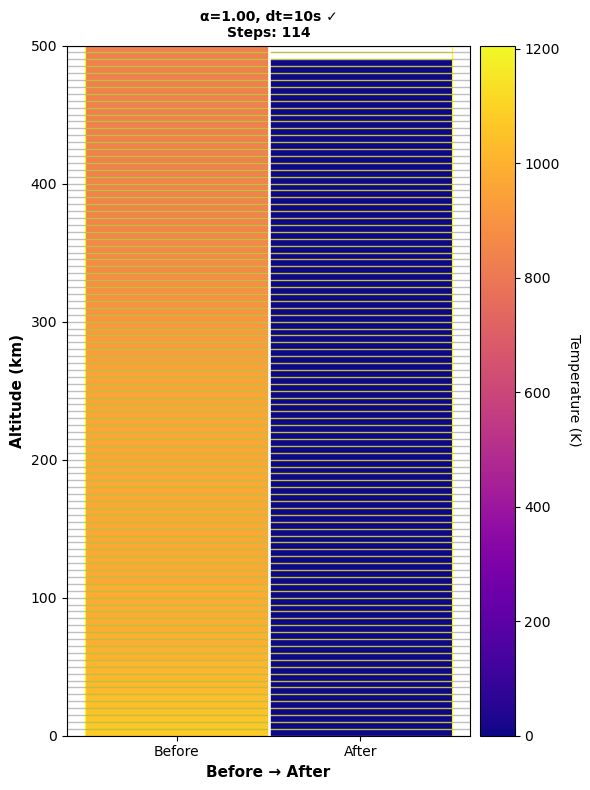

In [38]:
 plot_temperature_heatmap(alpha=1,timestep=10)  # All timesteps for alpha=0.1


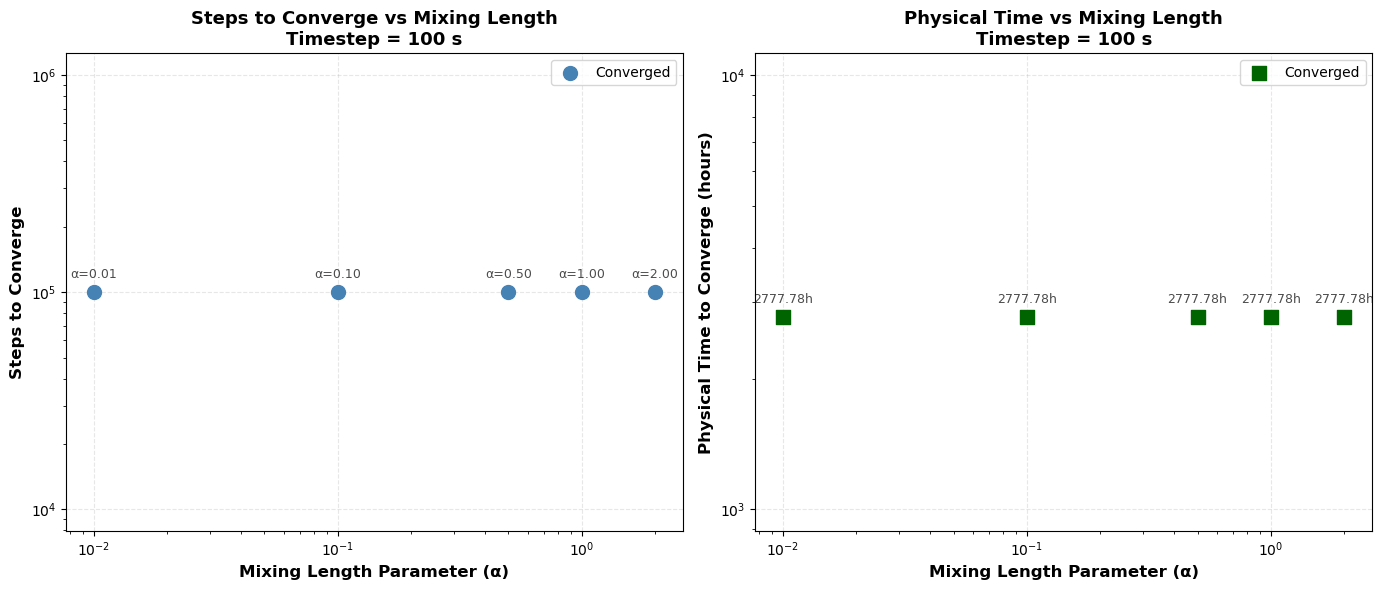


Summary for timestep = 100 s:
  Total runs: 5
  Converged: 5
  Not converged: 0
  Alpha range: [0.010, 2.000]
  Steps range (converged): [100000, 100000]
  Time range (converged): [2777.78, 2777.78] hours


In [4]:
 plot_convergence_vs_mixing_length(timestep=100)

In [6]:
# Cell 1: Overview Table
# Summary table showing key metrics for all parameter combinations

import json
import pandas as pd
import numpy as np

# Load data
with open('parameter_sweep_data.json', 'r') as f:
    data = json.load(f)

# Create summary table
summary_data = []
for run in data['data']:
    # Calculate mean temperature from T_final (at layer centers)
    # T_final is at interfaces, need to get layer centers
    T_final_interfaces = np.array(run['T_final'])
    T_centers = (T_final_interfaces[:-1] + T_final_interfaces[1:]) / 2.0
    
    summary_data.append({
        'alpha': run['alpha'],
        'timestep': run['timestep'],
        'steps_to_converge': run['steps_to_converge'],
        'converged': run['converged'],
        'n_convective_final': run['n_convective_final'],
        'max_grad_diff_final': run['max_grad_diff_final'],
        'mean_T_final': np.mean(T_centers),
        'min_T_final': np.min(T_centers),
        'max_T_final': np.max(T_centers)
    })

df_summary = pd.DataFrame(summary_data)

# Sort by alpha, then timestep for easy reading
df_summary = df_summary.sort_values(['alpha', 'timestep'])

# Display formatted table
print("=" * 100)
print("Parameter Effects Summary Table")
print("=" * 100)
print(f"\nTotal parameter combinations: {len(df_summary)}")
print(f"\n{df_summary.to_string(index=False)}\n")

# Print summary statistics
print("\n" + "=" * 100)
print("Summary Statistics by Parameter")
print("=" * 100)

# By alpha
print("\nBy Alpha (across all timesteps):")
alpha_stats = df_summary.groupby('alpha').agg({
    'steps_to_converge': ['mean', 'min', 'max'],
    'n_convective_final': ['mean', 'min', 'max'],
    'max_grad_diff_final': ['mean', 'min', 'max'],
    'mean_T_final': ['mean', 'std']
}).round(2)
print(alpha_stats)

# By timestep
print("\nBy Timestep (across all alpha values):")
timestep_stats = df_summary.groupby('timestep').agg({
    'steps_to_converge': ['mean', 'min', 'max'],
    'n_convective_final': ['mean', 'min', 'max'],
    'max_grad_diff_final': ['mean', 'min', 'max'],
    'mean_T_final': ['mean', 'std']
}).round(2)
print(timestep_stats)

Parameter Effects Summary Table

Total parameter combinations: 25

 alpha  timestep  steps_to_converge  converged  n_convective_final  max_grad_diff_final  mean_T_final  min_T_final  max_T_final
  0.01       1.0             100000       True                  58             0.483708    927.490890   830.652072  1043.902691
  0.01      10.0             100000       True                  73             0.093196    928.843347   830.652072  1038.497134
  0.01     100.0             100000       True                  76             0.003378    929.399664   830.652072  1038.101225
  0.01    1000.0             100000       True                   0                  NaN           NaN          NaN          NaN
  0.01   10000.0             100000       True                   0                  NaN           NaN          NaN          NaN
  0.10       1.0             100000       True                  76             0.003378    929.399664   830.652072  1038.101225
  0.10      10.0             100000  

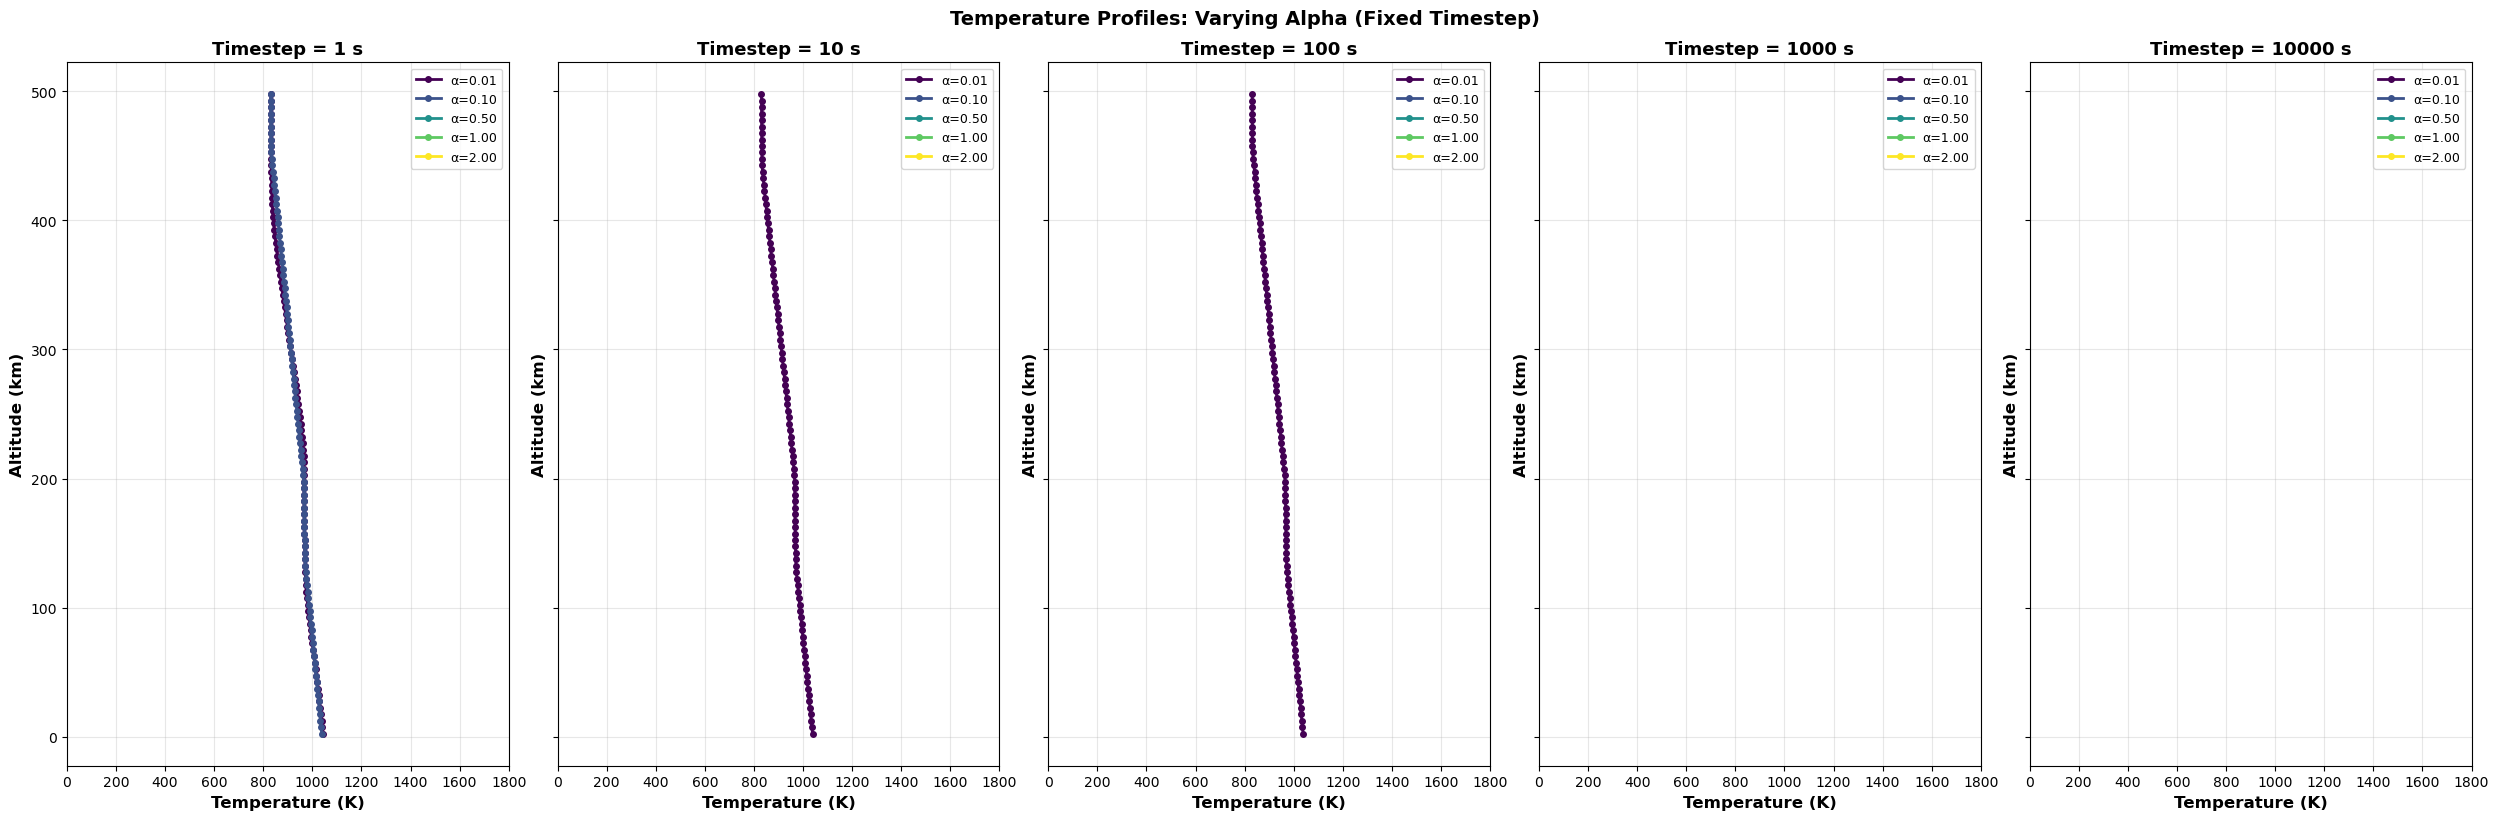

In [7]:
# Cell 2: Temperature Profile Comparison (Fixed timestep, varying alpha)
# Compare layer-by-layer temperature profiles for different alpha values at fixed timestep

import json
import numpy as np
import matplotlib.pyplot as plt

# Load data
with open('parameter_sweep_data.json', 'r') as f:
    data = json.load(f)

# Get unique timestep values
timesteps = sorted(set(run['timestep'] for run in data['data']))
alphas = sorted(set(run['alpha'] for run in data['data']))

# Create subplots: one per timestep
n_timesteps = len(timesteps)
fig, axes = plt.subplots(1, n_timesteps, figsize=(5*n_timesteps, 8), sharey=True)

if n_timesteps == 1:
    axes = [axes]

# Colors for different alpha values
colors = plt.cm.viridis(np.linspace(0, 1, len(alphas)))

for timestep_idx, timestep in enumerate(timesteps):
    ax = axes[timestep_idx]
    
    # Filter runs for this timestep
    runs_at_timestep = [run for run in data['data'] if abs(run['timestep'] - timestep) < 1e-6]
    
    # Plot one line per alpha value
    for alpha_idx, alpha in enumerate(alphas):
        runs_at_alpha = [run for run in runs_at_timestep if abs(run['alpha'] - alpha) < 1e-6]
        if len(runs_at_alpha) == 0:
            continue
        
        run = runs_at_alpha[0]
        
        # Get temperature at layer centers and altitude
        T_final_interfaces = np.array(run['T_final'])
        z_interfaces_km = np.array(run['z_interfaces_km'])
        
        # Calculate layer centers (average of adjacent interfaces)
        T_centers = (T_final_interfaces[:-1] + T_final_interfaces[1:]) / 2.0
        z_centers_km = (z_interfaces_km[:-1] + z_interfaces_km[1:]) / 2.0
        
        ax.plot(T_centers, z_centers_km, 'o-', color=colors[alpha_idx], 
               label=f'α={alpha:.2f}', linewidth=2, markersize=4)
    
    ax.set_xlabel('Temperature (K)', fontsize=12, fontweight='bold')
    ax.set_ylabel('Altitude (km)', fontsize=12, fontweight='bold')
    ax.set_title(f'Timestep = {timestep:.0f} s', fontsize=13, fontweight='bold')
    ax.grid(True, alpha=0.3)
    ax.legend(fontsize=9, loc='best')
  #  ax.invert_yaxis()  # Invert Y-axis so altitude increases upward
    ax.set_xlim(0,1800)

plt.tight_layout()
plt.suptitle('Temperature Profiles: Varying Alpha (Fixed Timestep)', 
             fontsize=14, fontweight='bold', y=1.02)
plt.show()

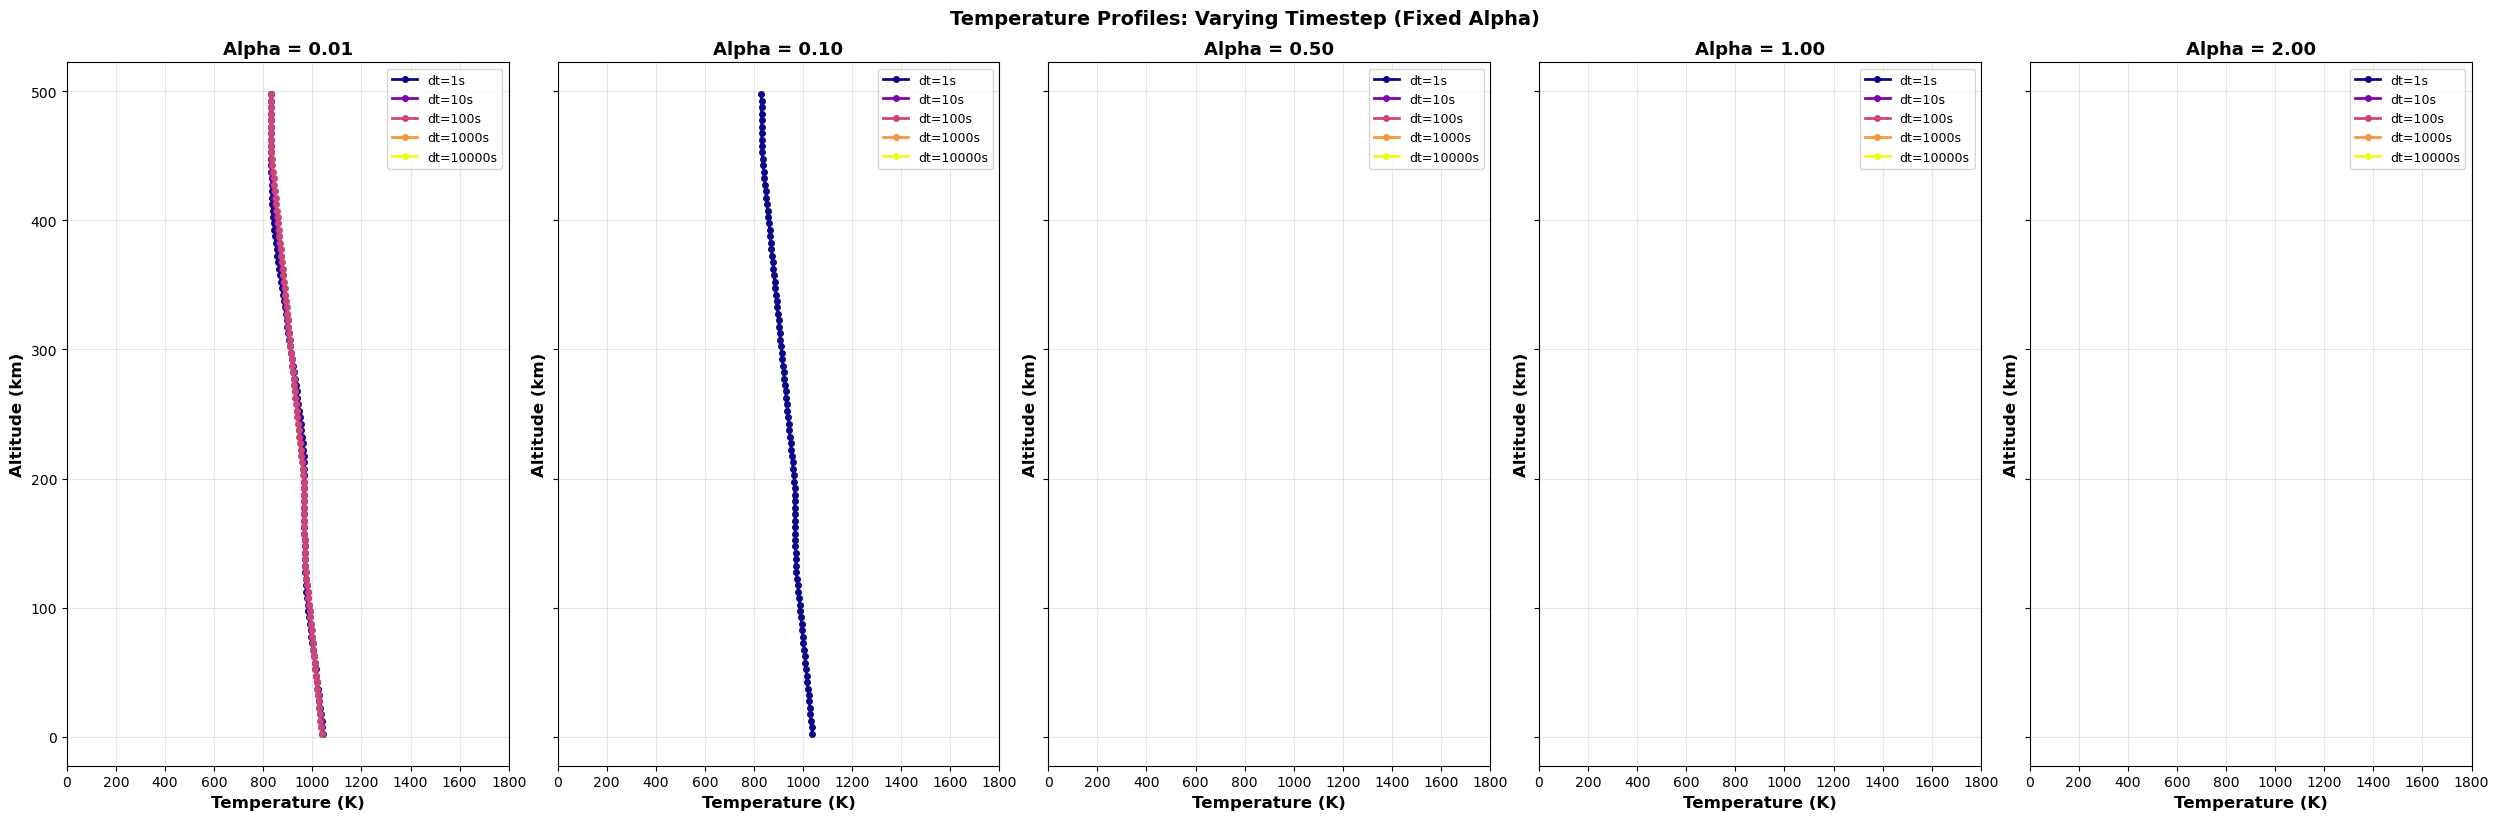

In [8]:
# Cell 3: Temperature Profile Comparison (Fixed alpha, varying timestep)
# Compare layer-by-layer temperature profiles for different timesteps at fixed alpha

import json
import numpy as np
import matplotlib.pyplot as plt

# Load data
with open('parameter_sweep_data.json', 'r') as f:
    data = json.load(f)

# Get unique timestep and alpha values
timesteps = sorted(set(run['timestep'] for run in data['data']))
alphas = sorted(set(run['alpha'] for run in data['data']))

# Create subplots: one per alpha
n_alphas = len(alphas)
fig, axes = plt.subplots(1, n_alphas, figsize=(5*n_alphas, 8), sharey=True)

if n_alphas == 1:
    axes = [axes]

# Colors for different timestep values
colors = plt.cm.plasma(np.linspace(0, 1, len(timesteps)))

for alpha_idx, alpha in enumerate(alphas):
    ax = axes[alpha_idx]
    
    # Filter runs for this alpha
    runs_at_alpha = [run for run in data['data'] if abs(run['alpha'] - alpha) < 1e-6]
    
    # Plot one line per timestep value
    for timestep_idx, timestep in enumerate(timesteps):
        runs_at_timestep = [run for run in runs_at_alpha if abs(run['timestep'] - timestep) < 1e-6]
        if len(runs_at_timestep) == 0:
            continue
        
        run = runs_at_timestep[0]
        
        # Get temperature at layer centers and altitude
        T_final_interfaces = np.array(run['T_final'])
        z_interfaces_km = np.array(run['z_interfaces_km'])
        
        # Calculate layer centers (average of adjacent interfaces)
        T_centers = (T_final_interfaces[:-1] + T_final_interfaces[1:]) / 2.0
        z_centers_km = (z_interfaces_km[:-1] + z_interfaces_km[1:]) / 2.0
        
        ax.plot(T_centers, z_centers_km, 'o-', color=colors[timestep_idx], 
               label=f'dt={timestep:.0f}s', linewidth=2, markersize=4)
    
    ax.set_xlabel('Temperature (K)', fontsize=12, fontweight='bold')
    ax.set_ylabel('Altitude (km)', fontsize=12, fontweight='bold')
    ax.set_title(f'Alpha = {alpha:.2f}', fontsize=13, fontweight='bold')
    ax.grid(True, alpha=0.3)
    ax.legend(fontsize=9, loc='best')
    ax.set_xlim(0,1800)
  #  ax.invert_yaxis()  # Invert Y-axis so altitude increases upward

plt.tight_layout()
plt.suptitle('Temperature Profiles: Varying Timestep (Fixed Alpha)', 
             fontsize=14, fontweight='bold', y=1.02)
plt.show()

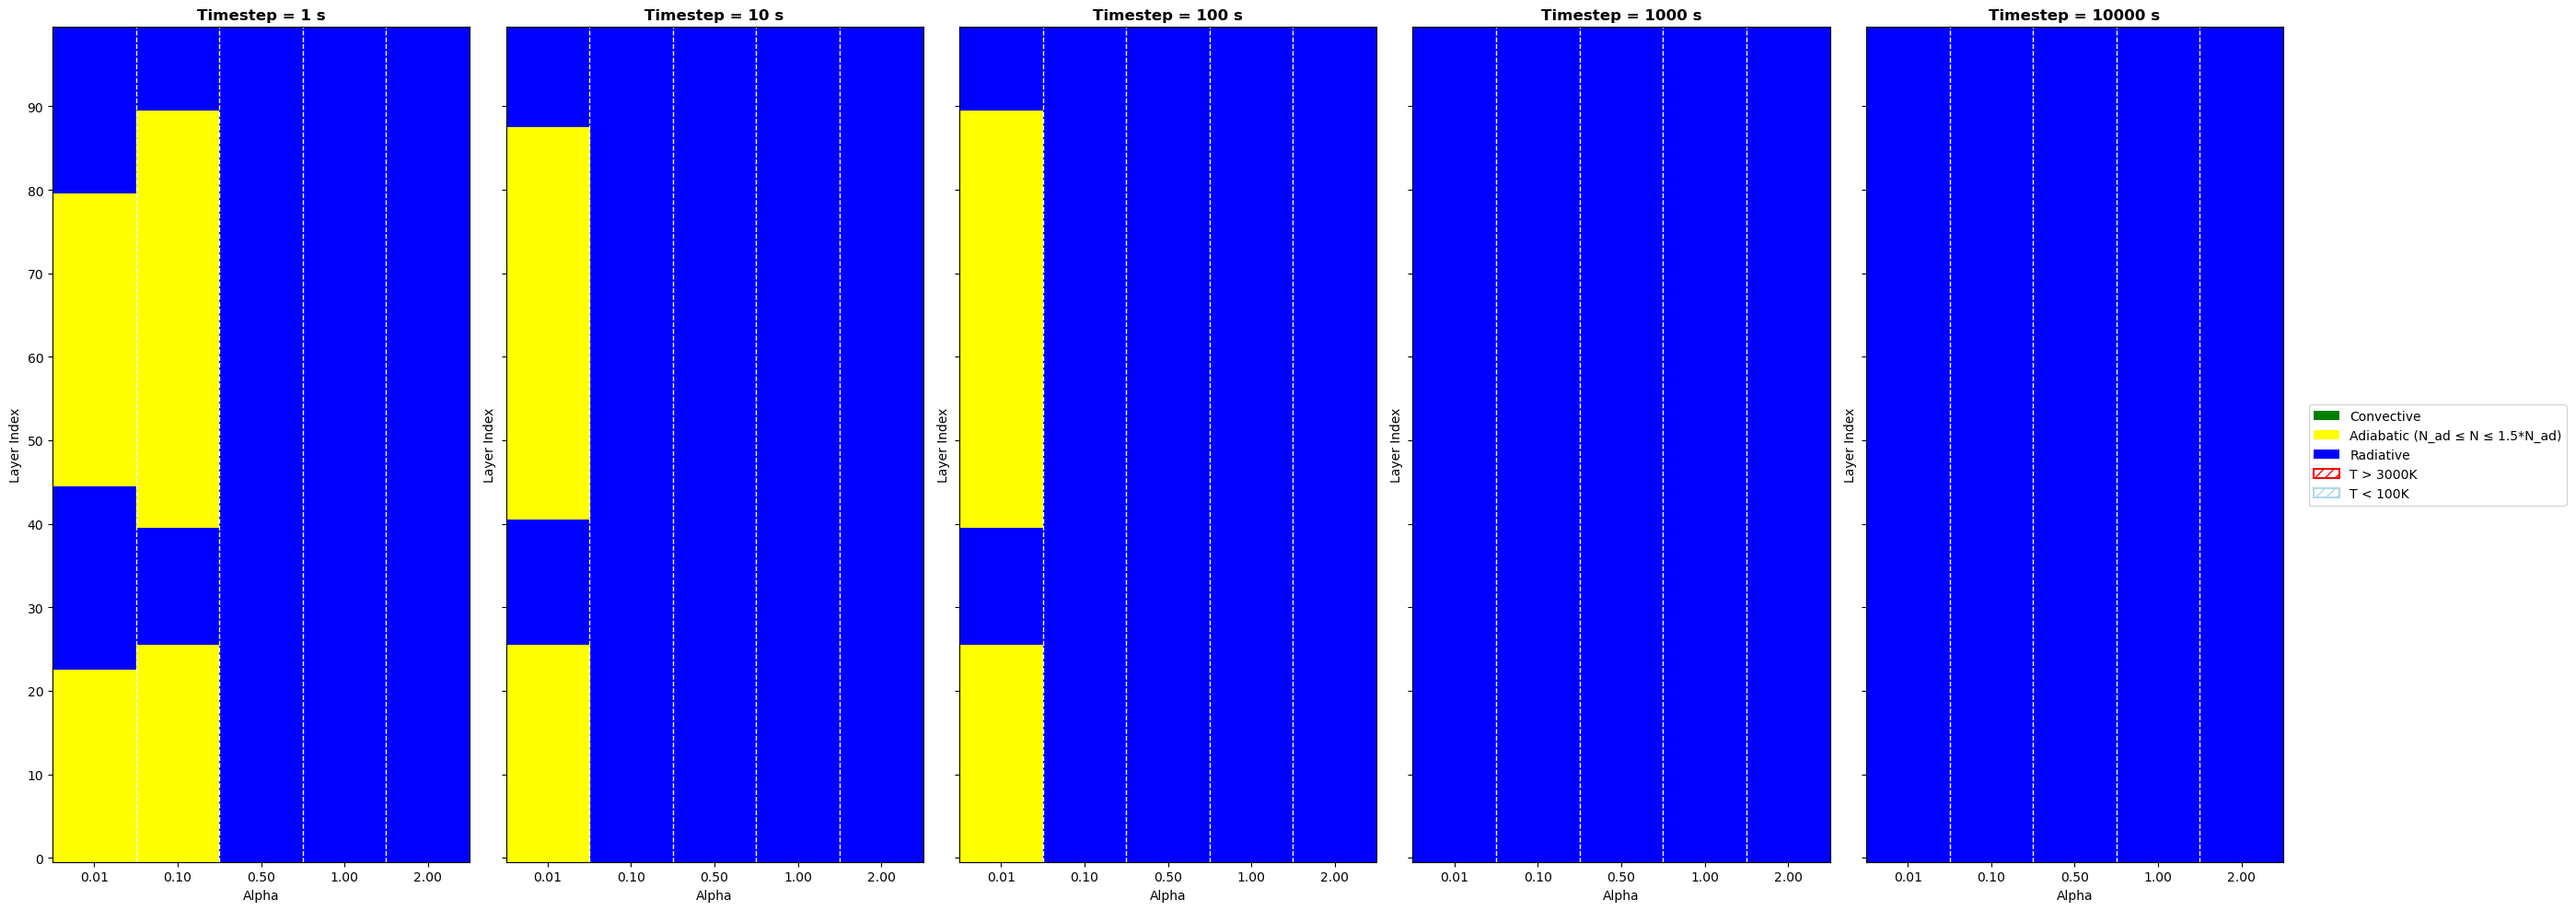

In [9]:
# Cell 4: Convective Layer Position Comparison
# Heatmap showing which layers are convective/radiative across parameters

import json
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib.patches import Rectangle, Patch

# Load data
with open('parameter_sweep_data.json', 'r') as f:
    data = json.load(f)

# Get unique timestep and alpha values
timesteps = sorted(set(run['timestep'] for run in data['data']))
alphas = sorted(set(run['alpha'] for run in data['data']))

# Get number of layers (assume all runs have same n_layers)
n_layers = data['data'][0]['n_layers']

def classify_layer_type_custom(N, N_ad):
    """
    Classify layers based on custom criterion:
    - Convective: N > 1.5*N_ad
    - Adiabatic: N_ad <= N <= 1.5*N_ad
    - Radiative: N < N_ad
    """
    classifications = np.empty(len(N), dtype=object)
    
    # Convective: N > 1.5*N_ad
    convective_mask = N > 1.5 * N_ad
    classifications[convective_mask] = 'convective'
    
    # Adiabatic: N_ad <= N <= 1.5*N_ad
    adiabatic_mask = (N >= N_ad) & (N <= 1.5 * N_ad)
    classifications[adiabatic_mask] = 'adiabatic'
    
    # Radiative: N < N_ad
    radiative_mask = N < N_ad
    classifications[radiative_mask] = 'radiative'
    
    return classifications

# Create two sets of plots
# Plot 1: Fixed timestep, varying alpha
fig1, axes1 = plt.subplots(1, len(timesteps), figsize=(5*len(timesteps), 10), sharey=True)

if len(timesteps) == 1:
    axes1 = [axes1]

# Custom colormap: convective=green, radiative=blue, adiabatic=yellow
colors_map = ['blue', 'yellow', 'green']  # radiative, adiabatic, convective
cmap = ListedColormap(colors_map)

# Create legend elements (used for both figures)
legend_elements = [
    Patch(facecolor='green', label='Convective'),
    Patch(facecolor='yellow', label='Adiabatic (N_ad ≤ N ≤ 1.5*N_ad)'),
    Patch(facecolor='blue', label='Radiative'),
    Patch(facecolor='white', edgecolor='red', hatch='///', linewidth=1.5, label='T > 3000K'),
    Patch(facecolor='white', edgecolor='lightblue', hatch='///', linewidth=1.5, label='T < 100K')
]

for timestep_idx, timestep in enumerate(timesteps):
    ax = axes1[timestep_idx]
    
    # Filter runs for this timestep
    runs_at_timestep = [run for run in data['data'] if abs(run['timestep'] - timestep) < 1e-6]
    
    # Create grid: layers (rows) vs alpha (columns)
    layer_type_grid = np.zeros((n_layers, len(alphas)), dtype=int)
    high_T_mask = np.zeros((n_layers, len(alphas)), dtype=bool)  # Mask for T > 3000K
    low_T_mask = np.zeros((n_layers, len(alphas)), dtype=bool)   # Mask for T < 100K
    
    for alpha_idx, alpha in enumerate(alphas):
        runs_at_alpha = [run for run in runs_at_timestep if abs(run['alpha'] - alpha) < 1e-6]
        if len(runs_at_alpha) == 0:
            continue
        
        run = runs_at_alpha[0]
        
        # Recalculate layer types using custom criterion (N_ad <= N <= 1.5*N_ad for adiabatic)
        N_final = np.array(run['N_final'])
        N_ad = run['N_ad']
        layer_types = classify_layer_type_custom(N_final, N_ad)
        
        # Get temperature at layer centers (average of adjacent interfaces)
        T_final_interfaces = np.array(run['T_final'])
        T_centers = (T_final_interfaces[:-1] + T_final_interfaces[1:]) / 2.0
        
        # Map layer types to integers: radiative=0, adiabatic=1, convective=2
        for layer_idx, layer_type in enumerate(layer_types):
            if layer_type == 'radiative':
                layer_type_grid[layer_idx, alpha_idx] = 0
            elif layer_type == 'adiabatic':
                layer_type_grid[layer_idx, alpha_idx] = 1
            elif layer_type == 'convective':
                layer_type_grid[layer_idx, alpha_idx] = 2
            
            # Check if temperature > 3000K
            if T_centers[layer_idx] > 3000.0:
                high_T_mask[layer_idx, alpha_idx] = True
            
            # Check if temperature < 100K
            if T_centers[layer_idx] < 100.0:
                low_T_mask[layer_idx, alpha_idx] = True
    
    # Create heatmap
    im = ax.imshow(layer_type_grid, aspect='auto', cmap=cmap, vmin=0, vmax=2, 
                   interpolation='nearest', origin='lower', extent=[-0.5, len(alphas)-0.5, -0.5, n_layers-0.5])
    
    # Overlay hatching for temperature conditions
    cell_width = 1.0
    cell_height = 1.0
    for layer_idx in range(n_layers):
        for alpha_idx in range(len(alphas)):
            # Red hatching for high temperature (T > 3000K)
            if high_T_mask[layer_idx, alpha_idx]:
                rect = Rectangle((alpha_idx - 0.5, layer_idx - 0.5), cell_width, cell_height,
                               fill=False, hatch='///', edgecolor='red', linewidth=1.5, alpha=0.8)
                ax.add_patch(rect)
            
            # Light blue hatching for low temperature (T < 100K)
            if low_T_mask[layer_idx, alpha_idx]:
                rect = Rectangle((alpha_idx - 0.5, layer_idx - 0.5), cell_width, cell_height,
                               fill=False, hatch='///', edgecolor='lightblue', linewidth=1.5, alpha=0.8)
                ax.add_patch(rect)
    
    # Add vertical lines between alpha values (halfway between ticks)
    for i in range(len(alphas) - 1):
        ax.axvline(x=i + 0.5, color='white', linestyle='--', linewidth=1, alpha=1)
    
    # Set ticks and labels
    ax.set_xticks(range(len(alphas)))
    ax.set_xticklabels([f'{alpha:.2f}' for alpha in alphas])
    ax.set_yticks(range(0, n_layers, max(1, n_layers//10)))
    ax.set_ylabel('Layer Index', fontsize=10)
    ax.set_xlabel('Alpha', fontsize=10)
    ax.set_title(f'Timestep = {timestep:.0f} s', fontsize=12, fontweight='bold')

fig1.tight_layout()

# Add legend to the first figure
fig1.legend(handles=legend_elements, loc='right', bbox_to_anchor=(1.12, 0.5), 
           ncol=1, fontsize=10, frameon=True)

plt.show()

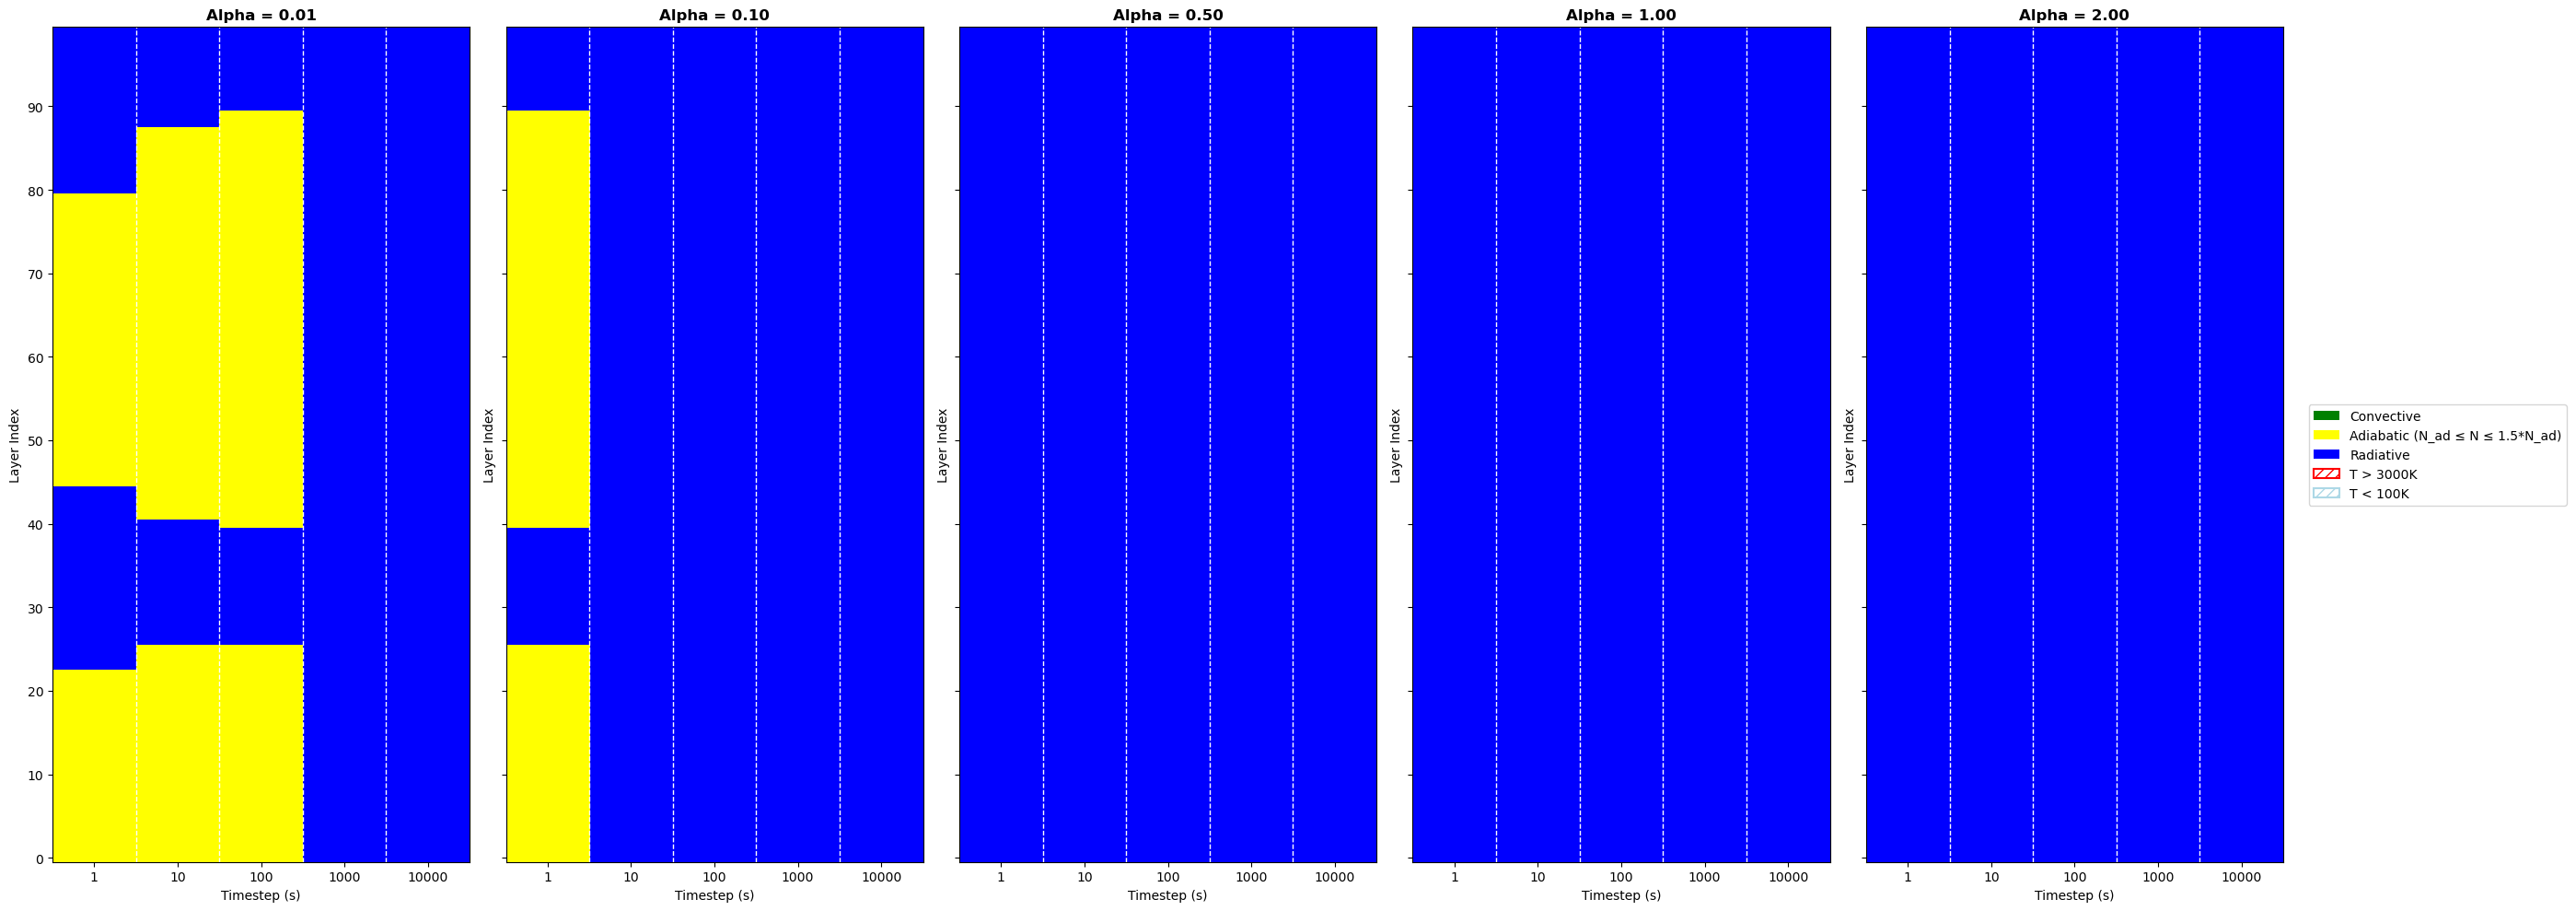

In [7]:
# Plot 2: Fixed alpha, varying timestep
# Load data and set up if needed
import json
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib.patches import Rectangle, Patch

with open('parameter_sweep_data.json', 'r') as f:
    data = json.load(f)

timesteps = sorted(set(run['timestep'] for run in data['data']))
alphas = sorted(set(run['alpha'] for run in data['data']))
n_layers = data['data'][0]['n_layers']

def classify_layer_type_custom(N, N_ad):
    classifications = np.empty(len(N), dtype=object)
    convective_mask = N > 1.5 * N_ad
    classifications[convective_mask] = 'convective'
    adiabatic_mask = (N >= N_ad) & (N <= 1.5 * N_ad)
    classifications[adiabatic_mask] = 'adiabatic'
    radiative_mask = N < N_ad
    classifications[radiative_mask] = 'radiative'
    return classifications

colors_map = ['blue', 'yellow', 'green']
cmap = ListedColormap(colors_map)

legend_elements = [
    Patch(facecolor='green', label='Convective'),
    Patch(facecolor='yellow', label='Adiabatic (N_ad ≤ N ≤ 1.5*N_ad)'),
    Patch(facecolor='blue', label='Radiative'),
    Patch(facecolor='white', edgecolor='red', hatch='///', linewidth=1.5, label='T > 3000K'),
    Patch(facecolor='white', edgecolor='lightblue', hatch='///', linewidth=1.5, label='T < 100K')
]

fig2, axes2 = plt.subplots(1, len(alphas), figsize=(5*len(alphas), 10), sharey=True)

if len(alphas) == 1:
    axes2 = [axes2]

for alpha_idx, alpha in enumerate(alphas):
    ax = axes2[alpha_idx]
    
    # Filter runs for this alpha
    runs_at_alpha = [run for run in data['data'] if abs(run['alpha'] - alpha) < 1e-6]
    
    # Create grid: layers (rows) vs timestep (columns)
    layer_type_grid = np.zeros((n_layers, len(timesteps)), dtype=int)
    high_T_mask = np.zeros((n_layers, len(timesteps)), dtype=bool)
    low_T_mask = np.zeros((n_layers, len(timesteps)), dtype=bool)
    
    for timestep_idx, timestep in enumerate(timesteps):
        runs_at_timestep = [run for run in runs_at_alpha if abs(run['timestep'] - timestep) < 1e-6]
        if len(runs_at_timestep) == 0:
            continue
        
        run = runs_at_timestep[0]
        
        # Recalculate layer types using custom criterion
        N_final = np.array(run['N_final'])
        N_ad = run['N_ad']
        layer_types = classify_layer_type_custom(N_final, N_ad)
        
        # Get temperature at layer centers
        T_final_interfaces = np.array(run['T_final'])
        T_centers = (T_final_interfaces[:-1] + T_final_interfaces[1:]) / 2.0
        
        # Map layer types to integers
        for layer_idx, layer_type in enumerate(layer_types):
            if layer_type == 'radiative':
                layer_type_grid[layer_idx, timestep_idx] = 0
            elif layer_type == 'adiabatic':
                layer_type_grid[layer_idx, timestep_idx] = 1
            elif layer_type == 'convective':
                layer_type_grid[layer_idx, timestep_idx] = 2
            
            if T_centers[layer_idx] > 3000.0:
                high_T_mask[layer_idx, timestep_idx] = True
            
            if T_centers[layer_idx] < 100.0:
                low_T_mask[layer_idx, timestep_idx] = True
    
    # Create heatmap
    im = ax.imshow(layer_type_grid, aspect='auto', cmap=cmap, vmin=0, vmax=2, 
                   interpolation='nearest', origin='lower', extent=[-0.5, len(timesteps)-0.5, -0.5, n_layers-0.5])
    
    # Overlay hatching for temperature conditions
    cell_width = 1.0
    cell_height = 1.0
    for layer_idx in range(n_layers):
        for timestep_idx in range(len(timesteps)):
            if high_T_mask[layer_idx, timestep_idx]:
                rect = Rectangle((timestep_idx - 0.5, layer_idx - 0.5), cell_width, cell_height,
                               fill=False, hatch='///', edgecolor='red', linewidth=1.5, alpha=0.8)
                ax.add_patch(rect)
            
            if low_T_mask[layer_idx, timestep_idx]:
                rect = Rectangle((timestep_idx - 0.5, layer_idx - 0.5), cell_width, cell_height,
                               fill=False, hatch='///', edgecolor='lightblue', linewidth=1.5, alpha=0.8)
                ax.add_patch(rect)
    
    # Add vertical lines between timestep values
    for i in range(len(timesteps) - 1):
        ax.axvline(x=i + 0.5, color='white', linestyle='--', linewidth=1, alpha=1)
    
    # Set ticks and labels
    ax.set_xticks(range(len(timesteps)))
    ax.set_xticklabels([f'{ts:.0f}' for ts in timesteps])
    ax.set_yticks(range(0, n_layers, max(1, n_layers//10)))
    ax.set_ylabel('Layer Index', fontsize=10)
    ax.set_xlabel('Timestep (s)', fontsize=10)
    ax.set_title(f'Alpha = {alpha:.2f}', fontsize=12, fontweight='bold')

fig2.tight_layout()

# Add legend to the second figure
fig2.legend(handles=legend_elements, loc='right', bbox_to_anchor=(1.12, 0.5), 
           ncol=1, fontsize=10, frameon=True)

plt.show()

✓ Found run in JSON data: α=0.1, dt=1s
  Converged: True, Steps: 100000
  Note: JSON doesn't contain dT history, so running simulation with save_history=True...

Running simulation with α=0.1, dt=1s...
Convective Flux Solver - Initialization
Specific heat capacity: c_p = 2.89e+08 erg g^-1 K^-1
Adiabatic gradient: N_ad = 0.0005 K/m
Grid: 100 layers, dz = 5.00 km
  Altitude range: 0 to 500.0 km
Profile type: guillot
Initial T range: [830.6, 1082.0] K
Initial rho range: [0.100, 1000.0] g/cm^3
Initial P range: [3.425e+03, 4.462e+07] bar
Temperature update method: Energy conservation (1/(ρc_p))

Starting iteration loop...

Reached maximum steps (100000) without convergence
  Final max|dT| = 0.000004 K

Final Results
Final T range: [830.6, 1039.4] K
Final rho range: [0.100, 1000.0] g/cm^3
Final P range: [3.425e+03, 4.286e+07] bar
Final F_conv range: [0.00e+00, 1.88e+12] erg cm^-2 s^-1
Convective layers: 76 / 100
N_ad = 0.000520 K/m, N_final = [5.19627935e-04 5.19652063e-04 5.19670632e-04 5.1

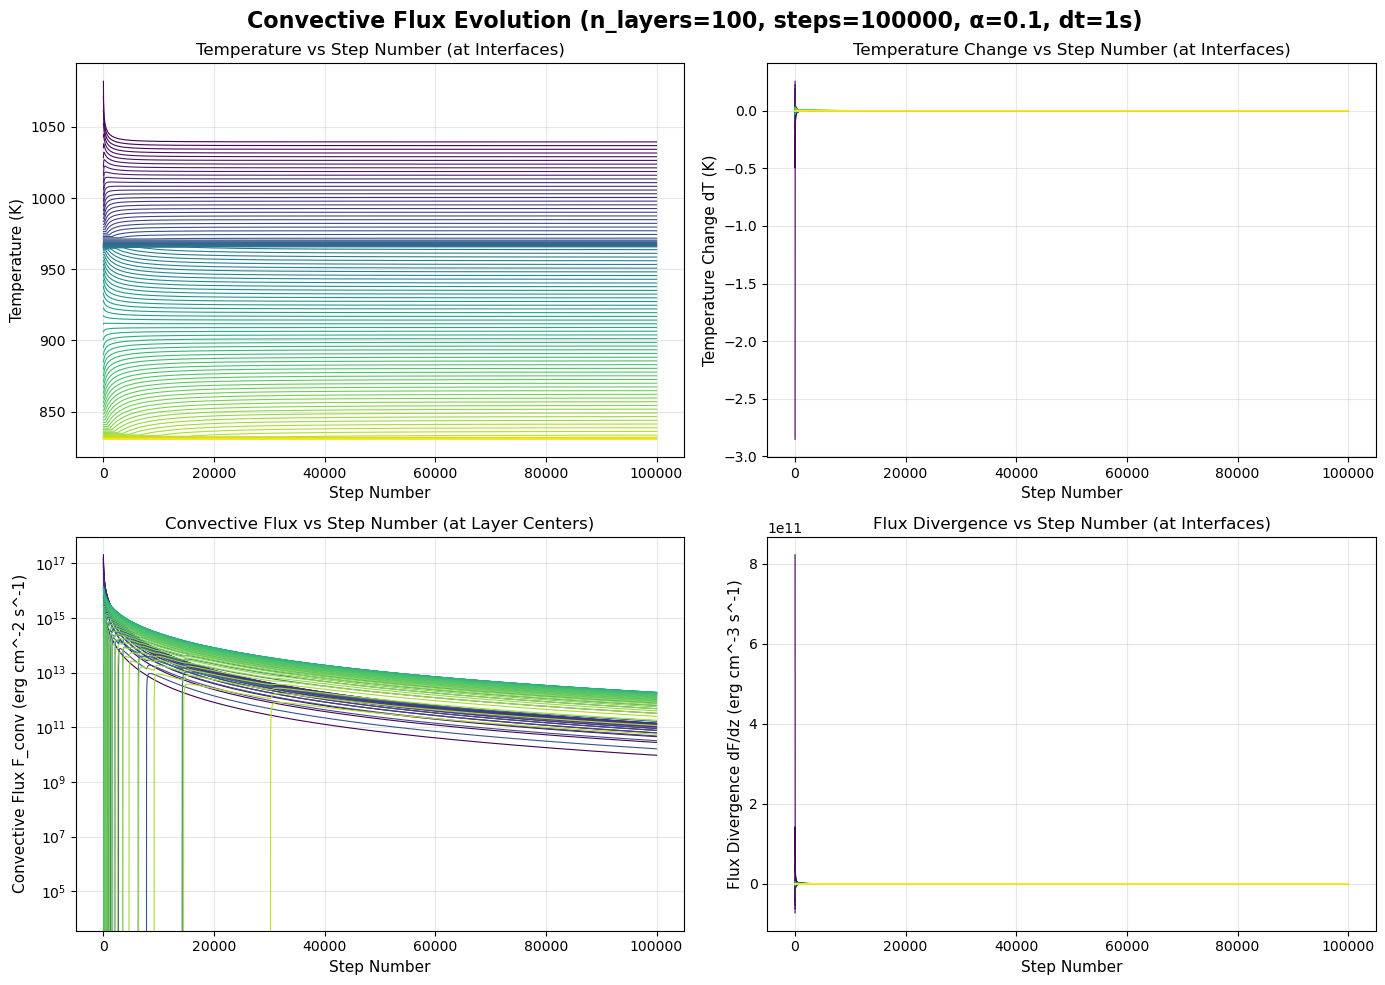


✓ Maximum temperature: 1082.00 K (within acceptable range)
  Final convergence: Converged
  Steps taken: 100000
  Number of layers: 100



In [9]:
# Cell: Plot 2x2 Summary (Temperature, dT, Flux, dFlux vs Step Number)
# Recreates the plot_results function from convective_flux_v2.py
# Input: alpha and timestep
# Output: 2x2 subplot showing Temperature, dT, Flux, and dFlux vs step number

import json
import numpy as np
import matplotlib.pyplot as plt
import sys
import os

# Add parent directory to path to import convective_flux_v2
sys.path.insert(0, os.path.dirname(os.path.abspath('.')))

# Import and reload to ensure we have the latest version with history_interval parameter
import importlib
if 'convective_grid.convective_flux_v2' in sys.modules:
    importlib.reload(sys.modules['convective_grid.convective_flux_v2'])

from convective_grid.convective_flux_v2 import run

# Parameters
alpha = 0.1  # Change this to your desired alpha
timestep = 1  # Change this to your desired timestep (in seconds)

# Load JSON data to check if run exists (for validation)
try:
    with open('parameter_sweep_data.json', 'r') as f:
        json_data = json.load(f)
    # Check if this combination exists in JSON
    matching_runs = [run for run in json_data['data'] 
                     if abs(run['alpha'] - alpha) < 1e-6 and abs(run['timestep'] - timestep) < 1e-6]
    if len(matching_runs) > 0:
        print(f"✓ Found run in JSON data: α={alpha}, dt={timestep}s")
        print(f"  Converged: {matching_runs[0]['converged']}, Steps: {matching_runs[0]['steps_to_converge']}")
        print("  Note: JSON doesn't contain dT history, so running simulation with save_history=True...")
except FileNotFoundError:
    print("Note: parameter_sweep_data.json not found. Running simulation directly...")
except Exception as e:
    print(f"Note: Could not load JSON ({e}). Running simulation directly...")

# Guillot profile parameters (same as in data collection)
GUILLOT_PARAMS = {
    'tint': 150.0,
    'tirr': 1200.0,
    'kappa_S': 0.01,
    'kappa0': 0.02,
    'kappa_cia': 0.0,
    'beta_S0': 1.0,
    'beta_L0': 1.0,
    'el1': 3.0/8.0,
    'el3': 1.0/3.0
}

# Run simulation with history tracking enabled
print(f"\nRunning simulation with α={alpha}, dt={timestep}s...")
print("=" * 70)

# Note: To get data at every step, we need to modify history saving
# The run() function saves history at intervals by default (max_steps // 1000)
# For now, we'll call run() and see what we get. If we need every step,
# we'll need to modify convective_flux_v2.py to use history_interval=1

z, T_final, rho_final, P_final, diagnostics = run(
    n_layers=100,
    max_steps=100000,
    alpha=alpha,
    dt=timestep,
    debug=False,
    save_history=True,  # Enable history tracking
    history_interval=1,  # Save at every step (not at intervals) to get all 100,000 data points
    profile_type="guillot",
    guillot_params=GUILLOT_PARAMS,
    convergence_tol=1e-10,
    check_adiabatic=True,
    adiabatic_tolerance=1.0
)

# Extract history data and create 2x2 plot (same as plot_results function)
if all(key in diagnostics for key in ['history_T', 'history_dT', 'history_F', 'history_dF', 'timesteps']):
    history_T = diagnostics['history_T']  # Shape: (n_steps, n_interfaces)
    history_dT = diagnostics['history_dT']  # Shape: (n_steps, n_interfaces)
    history_F = diagnostics['history_F']  # Shape: (n_steps, n_layers)
    history_dF = diagnostics['history_dF']  # Shape: (n_steps, n_interfaces)
    timesteps = diagnostics['timesteps']
    # z is the altitude at interfaces (returned from run())
    # z_mid is stored in diagnostics or computed from z
    if 'z_mid' in diagnostics:
        z_mid = diagnostics['z_mid']
    else:
        z_mid = (z[:-1] + z[1:]) / 2.0  # Compute layer center altitudes
    
    n_layers = len(z_mid)
    n_interfaces = len(z)
    n_steps = len(timesteps)
    
    # Debug: Print information about saved steps
    print(f"\nHistory data summary:")
    print(f"  Total saved snapshots: {n_steps}")
    print(f"  Step numbers range: {timesteps[0]} to {timesteps[-1]}")
    print(f"  Actual steps taken: {diagnostics.get('steps', 'unknown')}")
    print(f"  History interval (estimated): {(timesteps[-1] - timesteps[0]) // (n_steps - 1) if n_steps > 1 else 'N/A'}")
    
    # Determine if we should show legend (hide if too many layers)
    show_legend = n_layers <= 10
    
    # Create color map for layers
    colors = plt.cm.viridis(np.linspace(0, 1, n_interfaces))
    colors_layers = plt.cm.viridis(np.linspace(0, 1, n_layers))
    
    # Create 2x2 subplot figure
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    fig.suptitle(f'Convective Flux Evolution (n_layers={n_layers}, steps={n_steps}, α={alpha}, dt={timestep}s)', 
                 fontsize=16, fontweight='bold')
    
    # Plot 1: Temperature vs Timestep (at interfaces) - Top Left
    ax1 = axes[0, 0]
    for i in range(n_interfaces):
        label = f'Interface {i} (z={z[i]/1000:.1f} km)' if show_legend else None
        ax1.plot(timesteps, history_T[:, i], label=label, 
                color=colors[i], linewidth=0.8)
    ax1.set_xlabel('Step Number', fontsize=11)
    ax1.set_ylabel('Temperature (K)', fontsize=11)
    ax1.set_title('Temperature vs Step Number (at Interfaces)', fontsize=12)
    if show_legend:
        ax1.legend(fontsize=7, loc='best')
    ax1.grid(True, alpha=0.3)
    
    # Plot 2: dT vs Timestep (at interfaces) - Top Right
    ax2 = axes[0, 1]
    for i in range(n_interfaces):
        label = f'Interface {i} (z={z[i]/1000:.1f} km)' if show_legend else None
        ax2.plot(timesteps, history_dT[:, i], label=label, 
                color=colors[i], linewidth=0.8)
    ax2.set_xlabel('Step Number', fontsize=11)
    ax2.set_ylabel('Temperature Change dT (K)', fontsize=11)
    ax2.set_title('Temperature Change vs Step Number (at Interfaces)', fontsize=12)
    if show_legend:
        ax2.legend(fontsize=7, loc='best')
    ax2.grid(True, alpha=0.3)
    
    # Plot 3: Flux vs Timestep (at layer centers) - Bottom Left
    ax3 = axes[1, 0]
    for i in range(n_layers):
        label = f'Layer {i} (z={z_mid[i]/1000:.1f} km)' if show_legend else None
        ax3.plot(timesteps, history_F[:, i], label=label, 
                color=colors_layers[i], linewidth=0.8)
    ax3.set_xlabel('Step Number', fontsize=11)
    ax3.set_ylabel('Convective Flux F_conv (erg cm^-2 s^-1)', fontsize=11)
    ax3.set_title('Convective Flux vs Step Number (at Layer Centers)', fontsize=12)
    if show_legend:
        ax3.legend(fontsize=7, loc='best')
    ax3.grid(True, alpha=0.3)
    ax3.set_yscale('log')  # Log scale for flux
    
    # Plot 4: dFlux (dF/dz) vs Timestep (at interfaces) - Bottom Right
    ax4 = axes[1, 1]
    for i in range(n_interfaces):
        label = f'Interface {i} (z={z[i]/1000:.1f} km)' if show_legend else None
        ax4.plot(timesteps, history_dF[:, i], label=label, 
                color=colors[i], linewidth=0.8)
    ax4.set_xlabel('Step Number', fontsize=11)
    ax4.set_ylabel('Flux Divergence dF/dz (erg cm^-3 s^-1)', fontsize=11)
    ax4.set_title('Flux Divergence vs Step Number (at Interfaces)', fontsize=12)
    #ax4.set_xlim(2000,5000)
    #ax4.set_ylim(-100000, 100000)
    if show_legend:
        ax4.legend(fontsize=7, loc='best')
    ax4.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Check for high temperature and show error
    max_T = np.max(T_final)
    if 'history_T' in diagnostics:
        max_T_all_time = np.max([np.max(T_step) for T_step in diagnostics['history_T']])
    else:
        max_T_all_time = max_T
    
    print("\n" + "=" * 70)
    if max_T_all_time > 3000.0:
        print("⚠️  WARNING: HIGH TEMPERATURE DETECTED!")
        print("=" * 70)
        print(f"Maximum temperature during run: {max_T_all_time:.2f} K")
        print(f"This exceeds the 3000 K threshold by {max_T_all_time - 3000.0:.2f} K")
        print(f"Parameters: α={alpha}, dt={timestep}s")
        print("This may indicate numerical instability or unphysical behavior.")
    else:
        print(f"✓ Maximum temperature: {max_T_all_time:.2f} K (within acceptable range)")
        print(f"  Final convergence: {'Converged' if diagnostics.get('converged_adiabatic', False) else 'Not converged'}")
        print(f"  Steps taken: {diagnostics.get('steps', len(timesteps))}")
        print(f"  Number of layers: {n_layers}")
    print("=" * 70 + "\n")
else:
    print("ERROR: History data not available. Please ensure save_history=True in the run() call.")

/var/folders/yf/t3znkkmj3cl80yg68g9qqvdw0000gn/T/ipykernel_91774/224882906.py:50: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  ax.set_xlim(0,1000)


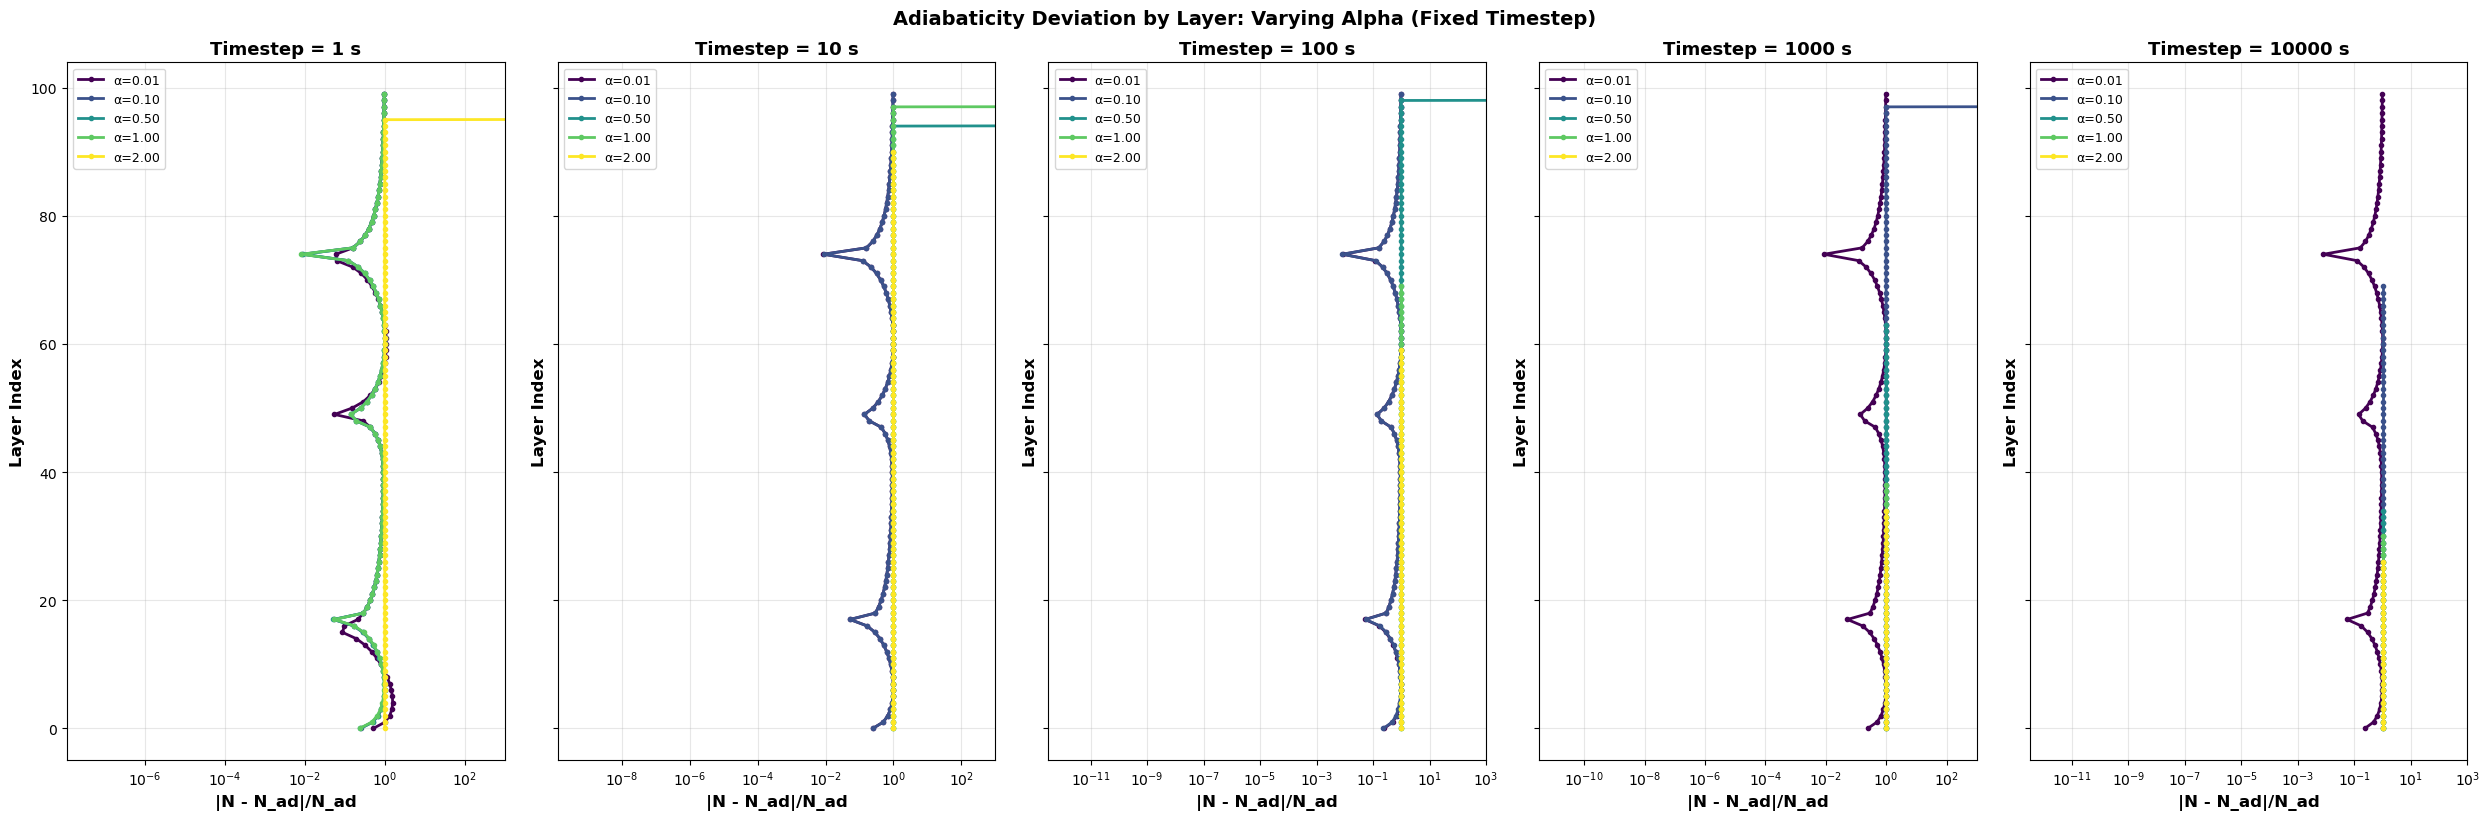

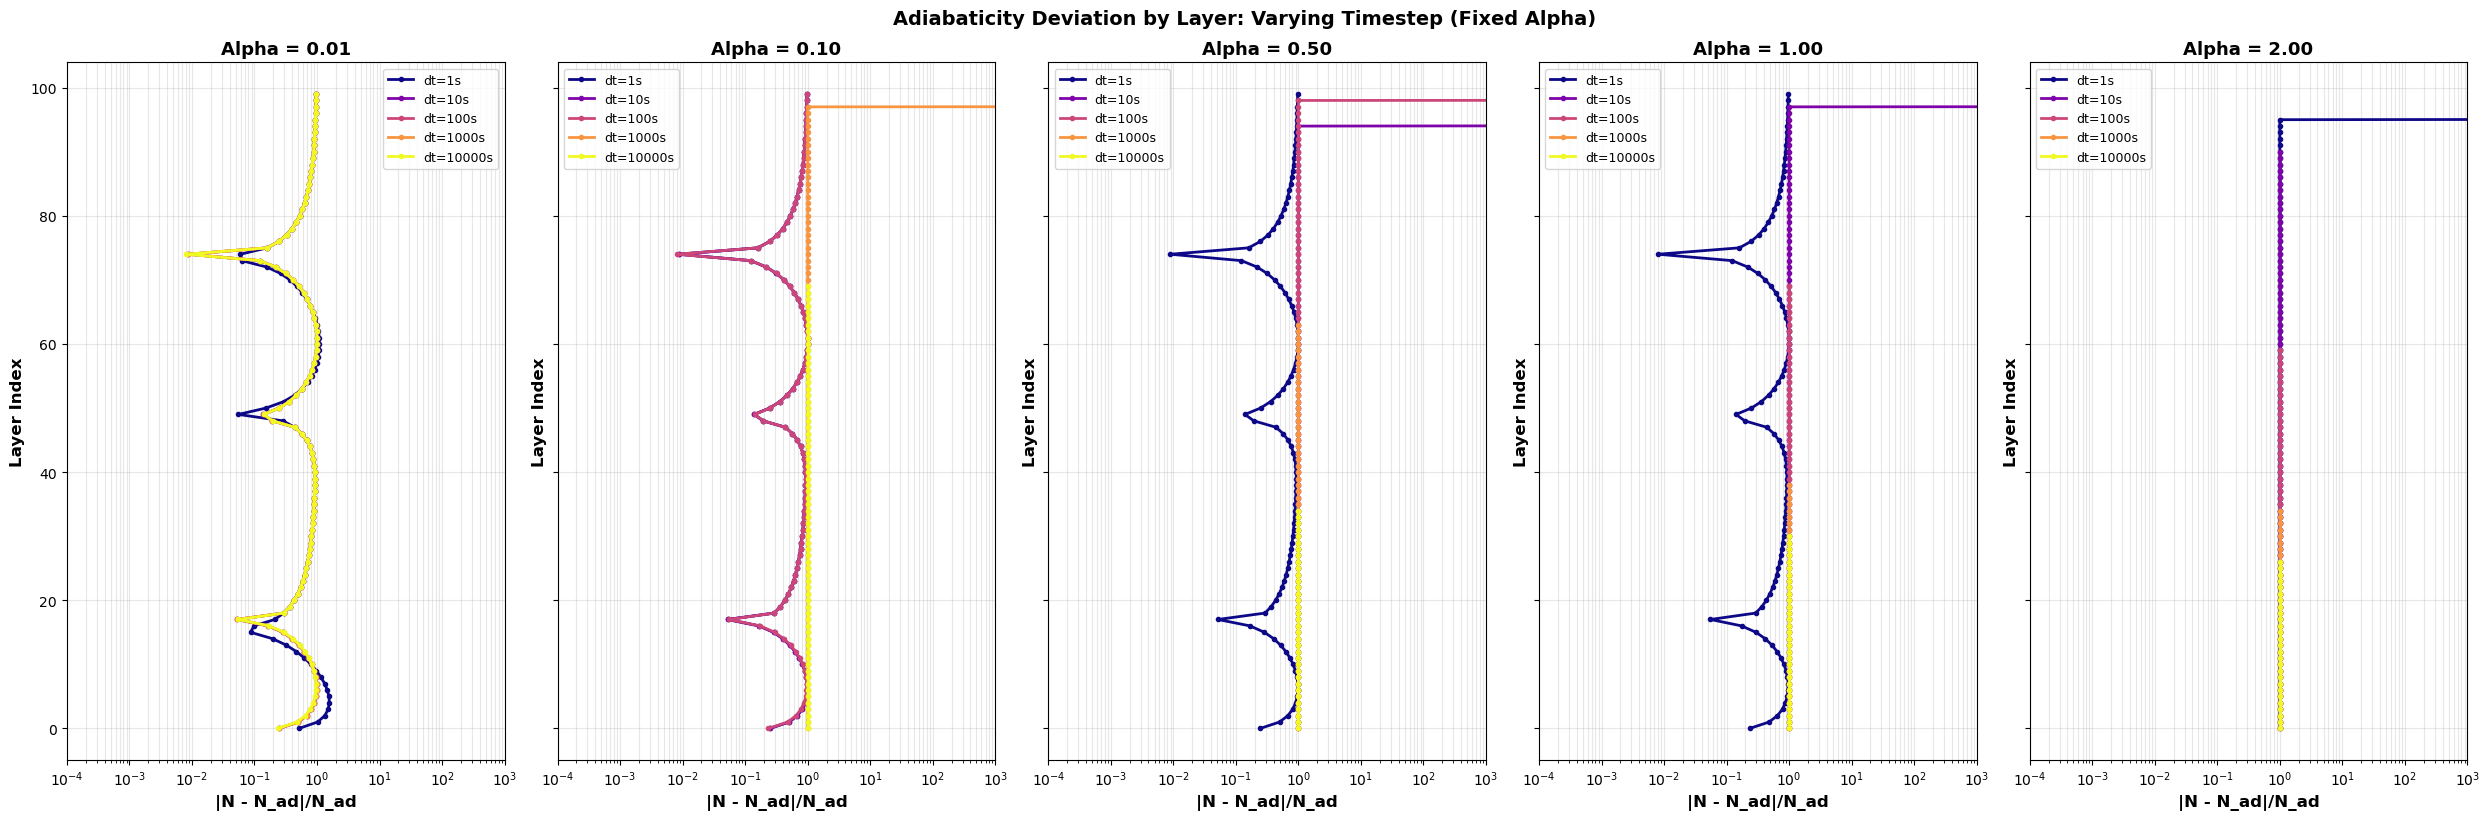

In [56]:
# Cell 5: Adiabaticity Deviation by Layer
# Plot |N - N_ad|/N_ad vs altitude for different parameter combinations

import json
import numpy as np
import matplotlib.pyplot as plt

# Load data
with open('parameter_sweep_data.json', 'r') as f:
    data = json.load(f)

# Get unique timestep and alpha values
timesteps = sorted(set(run['timestep'] for run in data['data']))
alphas = sorted(set(run['alpha'] for run in data['data']))

# Plot 1: Fixed timestep, varying alpha
fig1, axes1 = plt.subplots(1, len(timesteps), figsize=(5*len(timesteps), 8), sharey=True)

if len(timesteps) == 1:
    axes1 = [axes1]

# Colors for different alpha values
colors = plt.cm.viridis(np.linspace(0, 1, len(alphas)))

for timestep_idx, timestep in enumerate(timesteps):
    ax = axes1[timestep_idx]
    
    # Filter runs for this timestep
    runs_at_timestep = [run for run in data['data'] if abs(run['timestep'] - timestep) < 1e-6]
    
    # Plot one line per alpha value
    for alpha_idx, alpha in enumerate(alphas):
        runs_at_alpha = [run for run in runs_at_timestep if abs(run['alpha'] - alpha) < 1e-6]
        if len(runs_at_alpha) == 0:
            continue
        
        run = runs_at_alpha[0]
        
        # Get adiabaticity and layer indices
        layer_indices = np.arange(len(run['adiabaticity_final']))
        adiabaticity = np.array(run['adiabaticity_final'])
        
        ax.plot(adiabaticity,layer_indices, 'o-', color=colors[alpha_idx], 
               label=f'α={alpha:.2f}', linewidth=2, markersize=3)
    
    ax.set_ylabel('Layer Index', fontsize=12, fontweight='bold')
    ax.set_xlabel('|N - N_ad|/N_ad', fontsize=12, fontweight='bold')
    ax.set_title(f'Timestep = {timestep:.0f} s', fontsize=13, fontweight='bold')
    ax.set_xscale('log')
    ax.set_xlim(0,1000)
    ax.grid(True, alpha=0.3, which='both')
    ax.legend(fontsize=9, loc='best')

plt.tight_layout()
plt.suptitle('Adiabaticity Deviation by Layer: Varying Alpha (Fixed Timestep)', 
             fontsize=14, fontweight='bold', y=1.02)
plt.show()

# Plot 2: Fixed alpha, varying timestep
fig2, axes2 = plt.subplots(1, len(alphas), figsize=(5*len(alphas), 8), sharey=True)

if len(alphas) == 1:
    axes2 = [axes2]

# Colors for different timestep values
colors2 = plt.cm.plasma(np.linspace(0, 1, len(timesteps)))

for alpha_idx, alpha in enumerate(alphas):
    ax = axes2[alpha_idx]
    
    # Filter runs for this alpha
    runs_at_alpha = [run for run in data['data'] if abs(run['alpha'] - alpha) < 1e-6]
    
    # Plot one line per timestep value
    for timestep_idx, timestep in enumerate(timesteps):
        runs_at_timestep = [run for run in runs_at_alpha if abs(run['timestep'] - timestep) < 1e-6]
        if len(runs_at_timestep) == 0:
            continue
        
        run = runs_at_timestep[0]
        
        # Get adiabaticity and layer indices
        layer_indices = np.arange(len(run['adiabaticity_final']))
        adiabaticity = np.array(run['adiabaticity_final'])
        
        ax.plot(adiabaticity, layer_indices,'o-', color=colors2[timestep_idx], 
               label=f'dt={timestep:.0f}s', linewidth=2, markersize=3)
    
    ax.set_ylabel('Layer Index', fontsize=12, fontweight='bold')
    ax.set_xlabel('|N - N_ad|/N_ad', fontsize=12, fontweight='bold')
    ax.set_title(f'Alpha = {alpha:.2f}', fontsize=13, fontweight='bold')
    ax.set_xscale('log')
    ax.grid(True, alpha=0.3, which='both')
    ax.legend(fontsize=9, loc='best')
    ax.set_xlim(0.0001,1000)

plt.tight_layout()
plt.suptitle('Adiabaticity Deviation by Layer: Varying Timestep (Fixed Alpha)', 
             fontsize=14, fontweight='bold', y=1.02)
plt.show()

In [ ]:
# Cell 6: Statistical Comparison of Final States
# Quantify differences in final states across parameter combinations

import json
import numpy as np
import pandas as pd

# Load data
with open('parameter_sweep_data.json', 'r') as f:
    data = json.load(f)

def calculate_statistical_differences(data):
    """
    Calculate statistical differences between final states for different parameters.
    
    Compares:
    1. Temperature profiles: max|T_final - T_reference| across layers
    2. Convective layer overlap: How many convective layers overlap between runs?
    3. Adiabaticity difference: max|adiabaticity_final - adiabaticity_reference|
    """
    results = []
    
    # Use first run as reference
    reference_run = data['data'][0]
    T_ref_interfaces = np.array(reference_run['T_final'])
    T_ref_centers = (T_ref_interfaces[:-1] + T_ref_interfaces[1:]) / 2.0
    adiabaticity_ref = np.array(reference_run['adiabaticity_final'])
    convective_locs_ref = set(reference_run['convective_locations_final'])
    
    # Compare each run to reference
    for run in data['data']:
        # Temperature difference
        T_run_interfaces = np.array(run['T_final'])
        T_run_centers = (T_run_interfaces[:-1] + T_run_interfaces[1:]) / 2.0
        max_T_diff = np.max(np.abs(T_run_centers - T_ref_centers))
        mean_T_diff = np.mean(np.abs(T_run_centers - T_ref_centers))
        
        # Adiabaticity difference
        adiabaticity_run = np.array(run['adiabaticity_final'])
        max_adiabaticity_diff = np.max(np.abs(adiabaticity_run - adiabaticity_ref))
        mean_adiabaticity_diff = np.mean(np.abs(adiabaticity_run - adiabaticity_ref))
        
        # Convective layer overlap
        convective_locs_run = set(run['convective_locations_final'])
        overlap = len(convective_locs_ref & convective_locs_run)
        overlap_fraction = overlap / len(convective_locs_ref) if len(convective_locs_ref) > 0 else 0.0
        
        results.append({
            'alpha': run['alpha'],
            'timestep': run['timestep'],
            'max_T_diff': max_T_diff,
            'mean_T_diff': mean_T_diff,
            'max_adiabaticity_diff': max_adiabaticity_diff,
            'mean_adiabaticity_diff': mean_adiabaticity_diff,
            'convective_overlap': overlap,
            'convective_overlap_fraction': overlap_fraction,
            'n_convective': run['n_convective_final']
        })
    
    return pd.DataFrame(results)

# Calculate differences
df_stats = calculate_statistical_differences(data)

# Print summary statistics
print("=" * 100)
print("Statistical Comparison of Final States")
print("=" * 100)
print("\nReference run: alpha={:.2f}, timestep={:.0f}s".format(
    data['data'][0]['alpha'], data['data'][0]['timestep']))
print(f"Reference convective layers: {sorted(data['data'][0]['convective_locations_final'])}")
print(f"Reference n_convective: {data['data'][0]['n_convective_final']}")
print("\n" + "=" * 100)
print("Summary Statistics:")
print("=" * 100)

print(f"\nTemperature Differences (K):")
print(f"  Max difference across all runs: {df_stats['max_T_diff'].max():.2f} K")
print(f"  Mean difference across all runs: {df_stats['mean_T_diff'].mean():.2f} K")
print(f"  Std of mean differences: {df_stats['mean_T_diff'].std():.2f} K")

print(f"\nAdiabaticity Differences:")
print(f"  Max difference across all runs: {df_stats['max_adiabaticity_diff'].max():.4f}")
print(f"  Mean difference across all runs: {df_stats['mean_adiabaticity_diff'].mean():.4f}")
print(f"  Std of mean differences: {df_stats['mean_adiabaticity_diff'].std():.4f}")

print(f"\nConvective Layer Overlap:")
print(f"  Mean overlap fraction: {df_stats['convective_overlap_fraction'].mean():.2%}")
print(f"  Runs with 100% overlap: {(df_stats['convective_overlap_fraction'] == 1.0).sum()} / {len(df_stats)}")
print(f"  Runs with <50% overlap: {(df_stats['convective_overlap_fraction'] < 0.5).sum()} / {len(df_stats)}")

# Print detailed comparison table
print("\n" + "=" * 100)
print("Detailed Comparison (sorted by alpha, then timestep):")
print("=" * 100)
df_stats_sorted = df_stats.sort_values(['alpha', 'timestep'])
print(df_stats_sorted[['alpha', 'timestep', 'max_T_diff', 'mean_T_diff', 
                       'convective_overlap_fraction', 'n_convective']].to_string(index=False))

# Determine if parameters change final state or just convergence time
print("\n" + "=" * 100)
print("CONCLUSION:")
print("=" * 100)

if df_stats['max_T_diff'].max() < 10.0:  # If temperature differences are small (<10K)
    print("✓ TEMPERATURE PROFILES: Parameters appear to affect CONVERGENCE TIME only.")
    print(f"  Maximum temperature difference: {df_stats['max_T_diff'].max():.2f} K (very small)")
else:
    print("✗ TEMPERATURE PROFILES: Parameters affect the FINAL STATE.")
    print(f"  Maximum temperature difference: {df_stats['max_T_diff'].max():.2f} K")

if df_stats['convective_overlap_fraction'].mean() > 0.8:
    print("✓ CONVECTIVE LAYERS: Parameters appear to affect CONVERGENCE TIME only.")
    print(f"  Mean overlap: {df_stats['convective_overlap_fraction'].mean():.1%}")
else:
    print("✗ CONVECTIVE LAYERS: Parameters affect the FINAL STATE.")
    print(f"  Mean overlap: {df_stats['convective_overlap_fraction'].mean():.1%}")

if df_stats['max_adiabaticity_diff'].max() < 0.1:
    print("✓ ADIABATICITY: Parameters appear to affect CONVERGENCE TIME only.")
    print(f"  Maximum adiabaticity difference: {df_stats['max_adiabaticity_diff'].max():.4f}")
else:
    print("✗ ADIABATICITY: Parameters affect the FINAL STATE.")
    print(f"  Maximum adiabaticity difference: {df_stats['max_adiabaticity_diff'].max():.4f}")

Statistical Comparison of Final States

Reference run: alpha=0.01, timestep=1s
Reference convective layers: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73]
Reference n_convective: 40

Summary Statistics:

Temperature Differences (K):
  Max difference across all runs: 18311572612251997021213305719947473870043272351293851834691077949270834281306062639420540313184176314169168298532440343370222573897378893208329559590629203768368462056168718761907197256300232704.00 K
  Mean difference across all runs: 12207715074834665329803843945391279954787463389750127875312045341093757455372167614042678888329070331023015250390043614951104871131268888596868223081334644133753419024813485121114301622386688.00 K
  Std of mean differences: inf K

Adiabaticity Differences:
  Max difference across all runs: 1409651987946880625125512538557104502050559034816361306807470361761581197549076166922482258642358961580

/opt/anaconda3/lib/python3.13/site-packages/pandas/core/nanops.py:1016: RuntimeWarning: overflow encountered in square
  sqr = _ensure_numeric((avg - values) ** 2)


##### GUILLOT CHECK


In [8]:
import json

# Check if data file exists and what's in it
with open('parameter_sweep_data_guillot.json', 'r') as gf:
    gdata = json.load(gf)

print("Keys in data:", list(gdata.keys()))
if 'data' in gdata:
    print(f"Number of runs: {len(gdata['data'])}")
    if len(gdata['data']) > 0:
        print("First run keys:", list(gdata['data'][0].keys()))
        print("Available timesteps:", sorted(set(r['timestep'] for r in gdata['data'])))
    else:
        print("Data array is empty - need to run data collection!")
else:
    print("Data structure:", data)

Keys in data: ['metadata', 'data']
Number of runs: 25
First run keys: ['alpha', 'timestep', 'n_layers', 'converged', 'steps_to_converge', 'physical_time_to_converge', 'max_dT_final', 'max_grad_diff_final', 'n_convective_initial', 'n_adiabatic_initial', 'n_radiative_initial', 'n_convective_final', 'n_adiabatic_final', 'n_radiative_final', 'convective_locations_initial', 'adiabatic_locations_initial', 'radiative_locations_initial', 'convective_locations_final', 'adiabatic_locations_final', 'radiative_locations_final', 'convective_altitudes_initial', 'adiabatic_altitudes_initial', 'radiative_altitudes_initial', 'convective_altitudes_final', 'adiabatic_altitudes_final', 'radiative_altitudes_final', 'z_interfaces', 'z_interfaces_km', 'T_initial', 'T_final', 'P_initial', 'P_final', 'z_centers', 'z_centers_km', 'N_initial', 'N_final', 'N_ad', 'adiabaticity_initial', 'adiabaticity_final', 'adiabaticity_final_convective', 'layer_type_initial', 'layer_type_final', 'F_conv_final', 'rho_final', 't

In [9]:
# Cell 1: Overview Table
# Summary table showing key metrics for all parameter combinations

import json
import pandas as pd
import numpy as np

# Load data
with open('parameter_sweep_data_guillot.json', 'r') as gf:
    gdata = json.load(gf)

# Create summary table
gsummary_data = []
for run in gdata['data']:
    # Calculate mean temperature from T_final (at layer centers)
    # T_final is at interfaces, need to get layer centers
    T_final_interfaces = np.array(run['T_final'])
    T_centers = (T_final_interfaces[:-1] + T_final_interfaces[1:]) / 2.0
    
    gsummary_data.append({
        'alpha': run['alpha'],
        'timestep': run['timestep'],
        'steps_to_converge': run['steps_to_converge'],
        'converged': run['converged'],
        'n_convective_final': run['n_convective_final'],
        'max_grad_diff_final': run['max_grad_diff_final'],
        'mean_T_final': np.mean(T_centers),
        'min_T_final': np.min(T_centers),
        'max_T_final': np.max(T_centers)
    })

gdf_summary = pd.DataFrame(gsummary_data)

# Sort by alpha, then timestep for easy reading
gdf_summary = gdf_summary.sort_values(['alpha', 'timestep'])

# Display formatted table
print("=" * 100)
print("Parameter Effects Summary Table")
print("=" * 100)
print(f"\nTotal parameter combinations: {len(gdf_summary)}")
print(f"\n{gdf_summary.to_string(index=False)}\n")

# Print summary statistics
print("\n" + "=" * 100)
print("Summary Statistics by Parameter")
print("=" * 100)

# By alpha
print("\nBy Alpha (across all timesteps):")
alpha_stats = gdf_summary.groupby('alpha').agg({
    'steps_to_converge': ['mean', 'min', 'max'],
    'n_convective_final': ['mean', 'min', 'max'],
    'max_grad_diff_final': ['mean', 'min', 'max'],
    'mean_T_final': ['mean', 'std']
}).round(2)
print(alpha_stats)

# By timestep
print("\nBy Timestep (across all alpha values):")
timestep_stats = gdf_summary.groupby('timestep').agg({
    'steps_to_converge': ['mean', 'min', 'max'],
    'n_convective_final': ['mean', 'min', 'max'],
    'max_grad_diff_final': ['mean', 'min', 'max'],
    'mean_T_final': ['mean', 'std']
}).round(2)
print(timestep_stats)

KeyError: 'T_final'

KeyError: 'T_final'

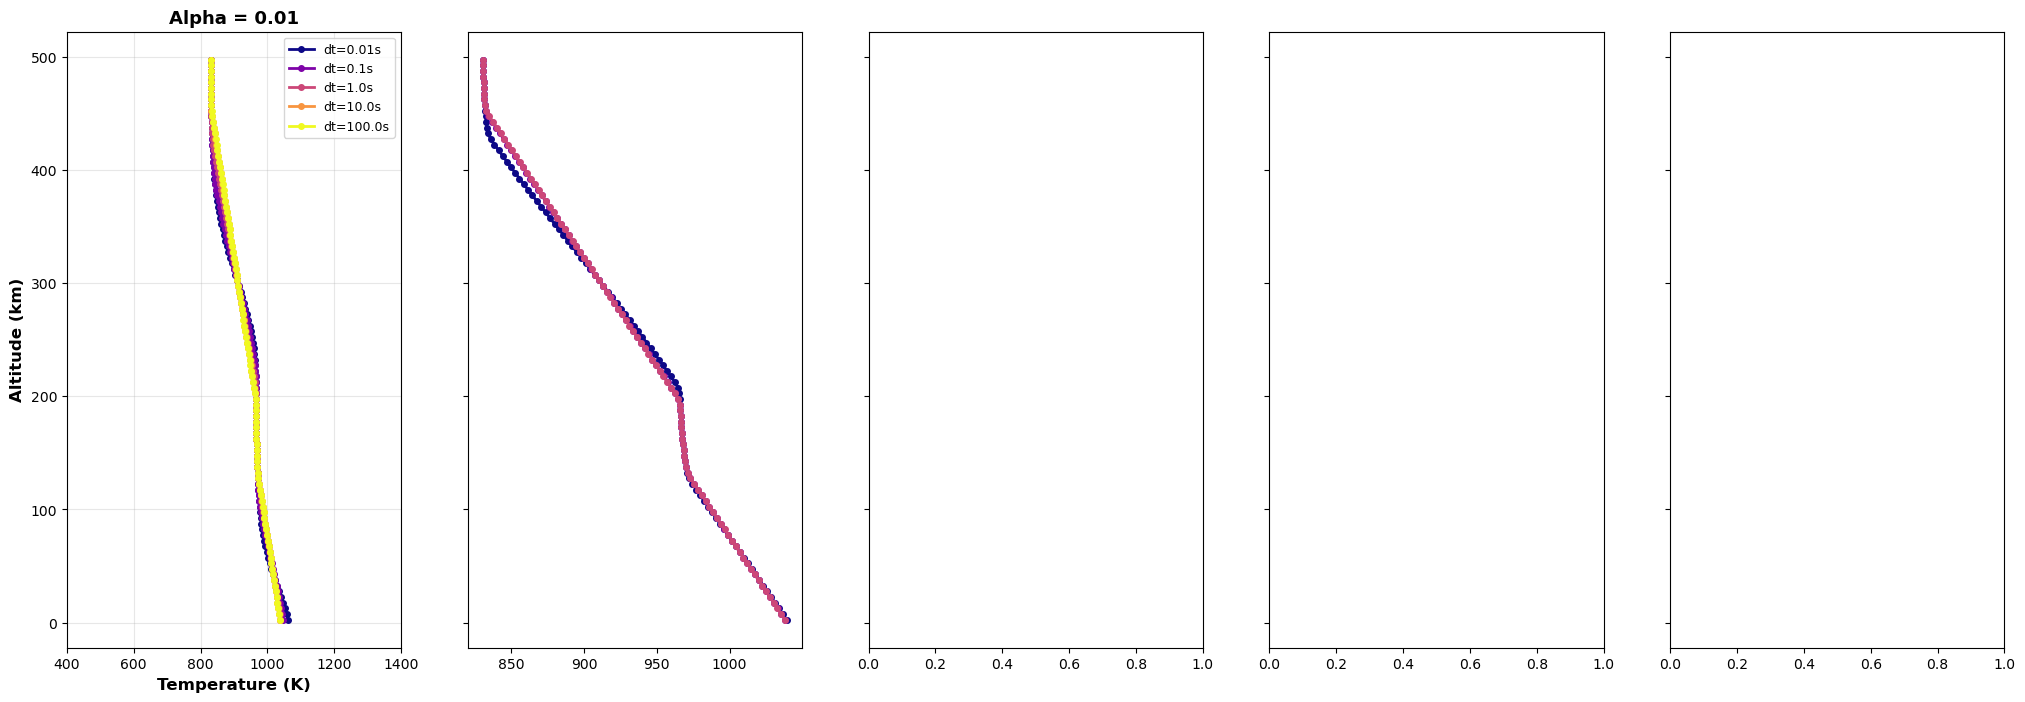

In [10]:
# Cell 3: Temperature Profile Comparison (Fixed alpha, varying timestep)
# Compare layer-by-layer temperature profiles for different timesteps at fixed alpha

import json
import numpy as np
import matplotlib.pyplot as plt

# Load data
with open('parameter_sweep_data_guillot.json', 'r') as gf:
    gdata = json.load(gf)

# Get unique timestep and alpha values
timesteps = sorted(set(run['timestep'] for run in gdata['data']))
alphas = sorted(set(run['alpha'] for run in gdata['data']))
# Create subplots: one per alpha
n_alphas = len(alphas)
fig, axes = plt.subplots(1, n_alphas, figsize=(5*n_alphas, 8), sharey=True)

if n_alphas == 1:
    axes = [axes]

# Colors for different timestep values
colors = plt.cm.plasma(np.linspace(0, 1, len(timesteps)))

for alpha_idx, alpha in enumerate(alphas):
    ax = axes[alpha_idx]
    
    # Filter runs for this alpha
    runs_at_alpha = [run for run in gdata['data'] if abs(run['alpha'] - alpha) < 1e-6]
    
    # Plot one line per timestep value
    for timestep_idx, timestep in enumerate(timesteps):
        runs_at_timestep = [run for run in runs_at_alpha if abs(run['timestep'] - timestep) < 1e-6]
        if len(runs_at_timestep) == 0:
            continue
        
        run = runs_at_timestep[0]
        
        # Get temperature at layer centers and altitude
        T_final_interfaces = np.array(run['T_final'])
        z_interfaces_km = np.array(run['z_interfaces_km'])
        
        # Calculate layer centers (average of adjacent interfaces)
        T_centers = (T_final_interfaces[:-1] + T_final_interfaces[1:]) / 2.0
        z_centers_km = (z_interfaces_km[:-1] + z_interfaces_km[1:]) / 2.0
        
        ax.plot(T_centers, z_centers_km, 'o-', color=colors[timestep_idx], 
               label=f'dt={timestep}s', linewidth=2, markersize=4)
    
    ax.set_xlabel('Temperature (K)', fontsize=12, fontweight='bold')
    ax.set_ylabel('Altitude (km)', fontsize=12, fontweight='bold')
    ax.set_title(f'Alpha = {alpha:.2f}', fontsize=13, fontweight='bold')
    ax.grid(True, alpha=0.3)
    ax.legend(fontsize=9, loc='best')
    ax.set_xlim(400,1400)
  #  ax.invert_yaxis()  # Invert Y-axis so altitude increases upward

plt.tight_layout()
plt.suptitle('Temperature Profiles: Varying Timestep (Fixed Alpha)', 
             fontsize=14, fontweight='bold', y=1.02)
plt.show()

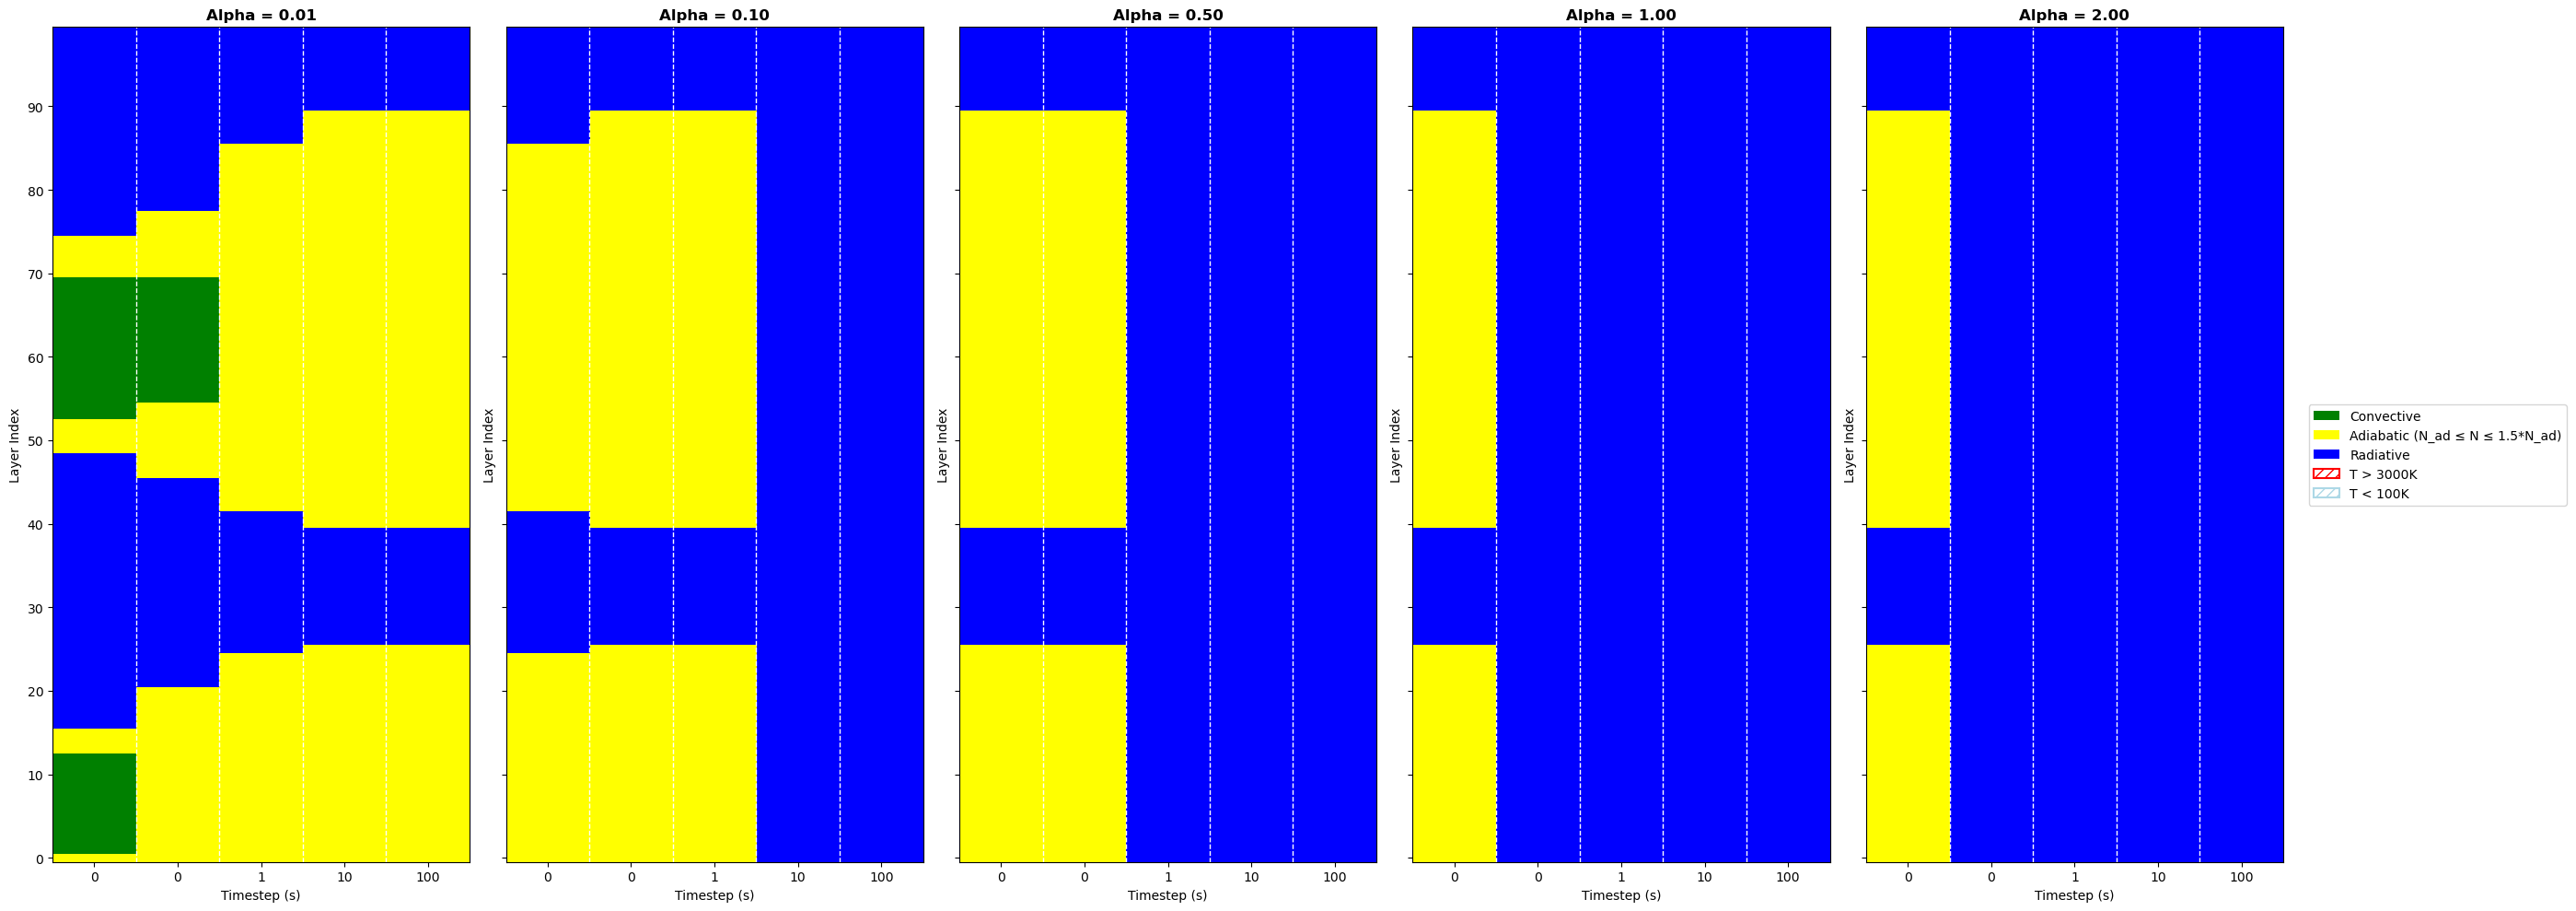

In [14]:
# Plot 2: Fixed alpha, varying timestep
# Load data and set up if needed
import json
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib.patches import Rectangle, Patch

with open('parameter_sweep_data_guillot.json', 'r') as gf:
    gdata = json.load(gf)

timesteps = sorted(set(run['timestep'] for run in gdata['data']))
alphas = sorted(set(run['alpha'] for run in gdata['data']))
n_layers = gdata['data'][0]['n_layers']

def classify_layer_type_custom(N, N_ad):
    classifications = np.empty(len(N), dtype=object)
    convective_mask = N > 1.5 * N_ad
    classifications[convective_mask] = 'convective'
    adiabatic_mask = (N >= N_ad) & (N <= 1.5 * N_ad)
    classifications[adiabatic_mask] = 'adiabatic'
    radiative_mask = N < N_ad
    classifications[radiative_mask] = 'radiative'
    return classifications

colors_map = ['blue', 'yellow', 'green']
cmap = ListedColormap(colors_map)

legend_elements = [
    Patch(facecolor='green', label='Convective'),
    Patch(facecolor='yellow', label='Adiabatic (N_ad ≤ N ≤ 1.5*N_ad)'),
    Patch(facecolor='blue', label='Radiative'),
    Patch(facecolor='white', edgecolor='red', hatch='///', linewidth=1.5, label='T > 3000K'),
    Patch(facecolor='white', edgecolor='lightblue', hatch='///', linewidth=1.5, label='T < 100K')
]

fig2, axes2 = plt.subplots(1, len(alphas), figsize=(5*len(alphas), 10), sharey=True)

if len(alphas) == 1:
    axes2 = [axes2]

for alpha_idx, alpha in enumerate(alphas):
    ax = axes2[alpha_idx]
    
    # Filter runs for this alpha
    runs_at_alpha = [run for run in gdata['data'] if abs(run['alpha'] - alpha) < 1e-6]
    
    # Create grid: layers (rows) vs timestep (columns)
    layer_type_grid = np.zeros((n_layers, len(timesteps)), dtype=int)
    high_T_mask = np.zeros((n_layers, len(timesteps)), dtype=bool)
    low_T_mask = np.zeros((n_layers, len(timesteps)), dtype=bool)
    
    for timestep_idx, timestep in enumerate(timesteps):
        runs_at_timestep = [run for run in runs_at_alpha if abs(run['timestep'] - timestep) < 1e-6]
        if len(runs_at_timestep) == 0:
            continue
        
        run = runs_at_timestep[0]
        
        # Recalculate layer types using custom criterion
        N_final = np.array(run['N_final'])
        N_ad = run['N_ad']
        layer_types = classify_layer_type_custom(N_final, N_ad)
        
        # Get temperature at layer centers
        T_final_interfaces = np.array(run['T_final'])
        T_centers = (T_final_interfaces[:-1] + T_final_interfaces[1:]) / 2.0
        
        # Map layer types to integers
        for layer_idx, layer_type in enumerate(layer_types):
            if layer_type == 'radiative':
                layer_type_grid[layer_idx, timestep_idx] = 0
            elif layer_type == 'adiabatic':
                layer_type_grid[layer_idx, timestep_idx] = 1
            elif layer_type == 'convective':
                layer_type_grid[layer_idx, timestep_idx] = 2
            
            if T_centers[layer_idx] > 3000.0:
                high_T_mask[layer_idx, timestep_idx] = True
            
            if T_centers[layer_idx] < 100.0:
                low_T_mask[layer_idx, timestep_idx] = True
    
    # Create heatmap
    im = ax.imshow(
        layer_type_grid,
        aspect='auto',
        cmap=cmap,
        vmin=0,
        vmax=2,
        interpolation='nearest',
        origin='lower',
        extent=[-0.5, len(timesteps)-0.5, -0.5, n_layers-0.5]
    )
    
    # Overlay hatching for temperature conditions
    cell_width = 1.0
    cell_height = 1.0
    for layer_idx in range(n_layers):
        for timestep_idx in range(len(timesteps)):
            if high_T_mask[layer_idx, timestep_idx]:
                rect = Rectangle(
                    (timestep_idx - 0.5, layer_idx - 0.5),
                    cell_width,
                    cell_height,
                    fill=False,
                    hatch='///',
                    edgecolor='red',
                    linewidth=1.5,
                    alpha=0.8
                )
                ax.add_patch(rect)
            
            if low_T_mask[layer_idx, timestep_idx]:
                rect = Rectangle(
                    (timestep_idx - 0.5, layer_idx - 0.5),
                    cell_width,
                    cell_height,
                    fill=False,
                    hatch='///',
                    edgecolor='lightblue',
                    linewidth=1.5,
                    alpha=0.8
                )
                ax.add_patch(rect)
    
    # Add vertical lines between timestep values
    for i in range(len(timesteps) - 1):
        ax.axvline(x=i + 0.5, color='white', linestyle='--', linewidth=1, alpha=1)
    
    # Set ticks and labels
    ax.set_xticks(range(len(timesteps)))
    ax.set_xticklabels([f'{ts:.0f}' for ts in timesteps])
    ax.set_yticks(range(0, n_layers, max(1, n_layers//10)))
    ax.set_ylabel('Layer Index', fontsize=10)
    ax.set_xlabel('Timestep (s)', fontsize=10)
    ax.set_title(f'Alpha = {alpha:.2f}', fontsize=12, fontweight='bold')

fig2.tight_layout()

# Add legend to the second figure
fig2.legend(
    handles=legend_elements,
    loc='right',
    bbox_to_anchor=(1.12, 0.5),
    ncol=1,
    fontsize=10,
    frameon=True
)

plt.show()


✓ Found run in JSON data: α=0.1, dt=1s
  Converged: True, Steps: 500000
  Note: JSON doesn't contain dT history, so running simulation with save_history=True...

Running simulation with α=0.1, dt=1s...
Convective Flux Solver - Initialization
Specific heat capacity: c_p = 2.89e+08 erg g^-1 K^-1
Adiabatic gradient: N_ad = 0.0005 K/m
Grid: 100 layers, dz = 5.00 km
  Altitude range: 0 to 500.0 km
Profile type: guillot
Initial T range: [830.6, 1082.0] K
Initial rho range: [0.100, 1000.0] g/cm^3
Initial P range: [3.425e+03, 4.462e+07] bar
Temperature update method: Energy conservation (1/(ρc_p))

Starting iteration loop...

Reached maximum steps (100000) without convergence
  Final max|dT| = 0.000004 K

Final Results
Final T range: [830.6, 1039.4] K
Final rho range: [0.100, 1000.0] g/cm^3
Final P range: [3.425e+03, 4.286e+07] bar
Final F_conv range: [0.00e+00, 1.88e+12] erg cm^-2 s^-1
Convective layers: 76 / 100
N_ad = 0.000520 K/m, N_final = [5.19627935e-04 5.19652063e-04 5.19670632e-04 5.1

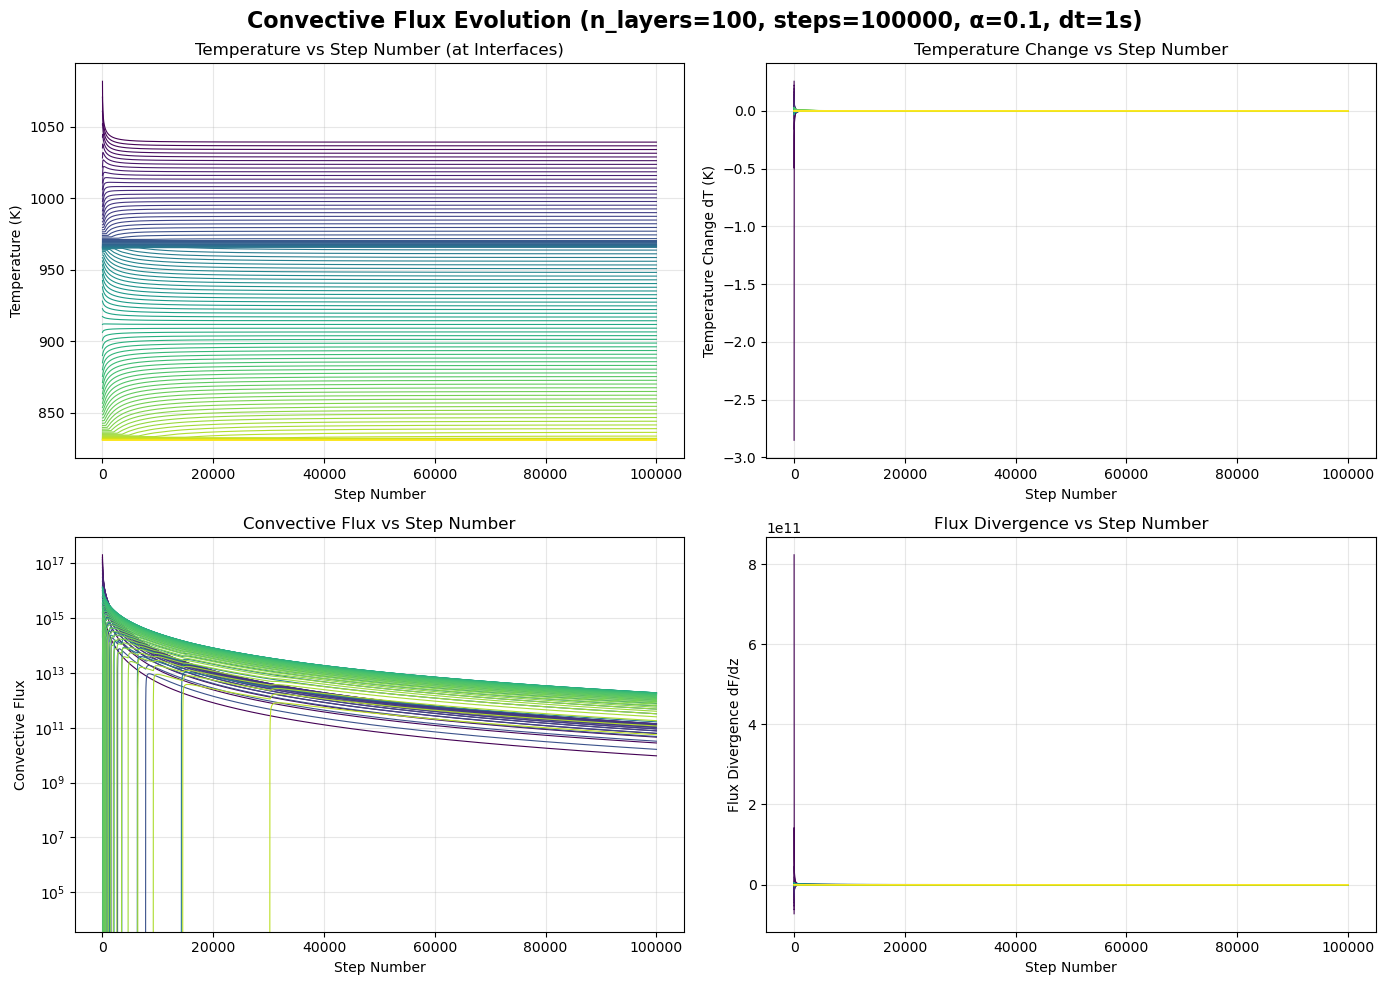

In [15]:
# Cell: Plot 2x2 Summary (Temperature, dT, Flux, dFlux vs Step Number)
# Recreates the plot_results function from convective_flux_v2.py
# Input: alpha and timestep
# Output: 2x2 subplot showing Temperature, dT, Flux, and dFlux vs step number

import json
import numpy as np
import matplotlib.pyplot as plt
import sys
import os

# Add parent directory to path to import convective_flux_v2
sys.path.insert(0, os.path.dirname(os.path.abspath('.')))

# Import and reload to ensure we have the latest version with history_interval parameter
import importlib
if 'convective_grid.convective_flux_v2' in sys.modules:
    importlib.reload(sys.modules['convective_grid.convective_flux_v2'])

from convective_grid.convective_flux_v2 import run

# Parameters
alpha = 0.1  # Change this to your desired alpha
timestep = 1  # Change this to your desired timestep (in seconds)

# Load JSON data to check if run exists (for validation)
try:
    with open('parameter_sweep_data_guillot.json', 'r') as gf:
        gdata = json.load(gf)
    # Check if this combination exists in JSON
    matching_runs = [
        run for run in gdata['data']
        if abs(run['alpha'] - alpha) < 1e-6 and abs(run['timestep'] - timestep) < 1e-6
    ]
    if len(matching_runs) > 0:
        print(f"✓ Found run in JSON data: α={alpha}, dt={timestep}s")
        print(f"  Converged: {matching_runs[0]['converged']}, Steps: {matching_runs[0]['steps_to_converge']}")
        print("  Note: JSON doesn't contain dT history, so running simulation with save_history=True...")
except FileNotFoundError:
    print("Note: parameter_sweep_data.json not found. Running simulation directly...")
except Exception as e:
    print(f"Note: Could not load JSON ({e}). Running simulation directly...")

# Guillot profile parameters (same as in data collection)
GUILLOT_PARAMS = {
    'tint': 150.0,
    'tirr': 1200.0,
    'kappa_S': 0.01,
    'kappa0': 0.02,
    'kappa_cia': 0.0,
    'beta_S0': 1.0,
    'beta_L0': 1.0,
    'el1': 3.0/8.0,
    'el3': 1.0/3.0
}

# Run simulation with history tracking enabled
print(f"\nRunning simulation with α={alpha}, dt={timestep}s...")
print("=" * 70)

z, T_final, rho_final, P_final, diagnostics = run(
    n_layers=100,
    max_steps=100000,
    alpha=alpha,
    dt=timestep,
    debug=False,
    save_history=True,
    history_interval=1,
    profile_type="guillot",
    guillot_params=GUILLOT_PARAMS,
    convergence_tol=1e-10,
    check_adiabatic=True,
    adiabatic_tolerance=1.0
)

# Extract history data and create 2x2 plot (same as plot_results function)
if all(key in diagnostics for key in ['history_T', 'history_dT', 'history_F', 'history_dF', 'timesteps']):
    history_T = diagnostics['history_T']
    history_dT = diagnostics['history_dT']
    history_F = diagnostics['history_F']
    history_dF = diagnostics['history_dF']
    timesteps = diagnostics['timesteps']

    if 'z_mid' in diagnostics:
        z_mid = diagnostics['z_mid']
    else:
        z_mid = (z[:-1] + z[1:]) / 2.0

    n_layers = len(z_mid)
    n_interfaces = len(z)
    n_steps = len(timesteps)

    print(f"\nHistory data summary:")
    print(f"  Total saved snapshots: {n_steps}")
    print(f"  Step numbers range: {timesteps[0]} to {timesteps[-1]}")
    print(f"  Actual steps taken: {diagnostics.get('steps', 'unknown')}")
    print(f"  History interval (estimated): {(timesteps[-1] - timesteps[0]) // (n_steps - 1) if n_steps > 1 else 'N/A'}")

    show_legend = n_layers <= 10

    colors = plt.cm.viridis(np.linspace(0, 1, n_interfaces))
    colors_layers = plt.cm.viridis(np.linspace(0, 1, n_layers))

    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    fig.suptitle(
        f'Convective Flux Evolution (n_layers={n_layers}, steps={n_steps}, α={alpha}, dt={timestep}s)',
        fontsize=16,
        fontweight='bold'
    )

    ax1 = axes[0, 0]
    for i in range(n_interfaces):
        label = f'Interface {i} (z={z[i]/1000:.1f} km)' if show_legend else None
        ax1.plot(timesteps, history_T[:, i], label=label, color=colors[i], linewidth=0.8)
    ax1.set_xlabel('Step Number')
    ax1.set_ylabel('Temperature (K)')
    ax1.set_title('Temperature vs Step Number (at Interfaces)')
    if show_legend:
        ax1.legend(fontsize=7)
    ax1.grid(True, alpha=0.3)

    ax2 = axes[0, 1]
    for i in range(n_interfaces):
        label = f'Interface {i} (z={z[i]/1000:.1f} km)' if show_legend else None
        ax2.plot(timesteps, history_dT[:, i], label=label, color=colors[i], linewidth=0.8)
    ax2.set_xlabel('Step Number')
    ax2.set_ylabel('Temperature Change dT (K)')
    ax2.set_title('Temperature Change vs Step Number')
    if show_legend:
        ax2.legend(fontsize=7)
    ax2.grid(True, alpha=0.3)

    ax3 = axes[1, 0]
    for i in range(n_layers):
        label = f'Layer {i} (z={z_mid[i]/1000:.1f} km)' if show_legend else None
        ax3.plot(timesteps, history_F[:, i], label=label, color=colors_layers[i], linewidth=0.8)
    ax3.set_xlabel('Step Number')
    ax3.set_ylabel('Convective Flux')
    ax3.set_title('Convective Flux vs Step Number')
    ax3.set_yscale('log')
    if show_legend:
        ax3.legend(fontsize=7)
    ax3.grid(True, alpha=0.3)

    ax4 = axes[1, 1]
    for i in range(n_interfaces):
        label = f'Interface {i} (z={z[i]/1000:.1f} km)' if show_legend else None
        ax4.plot(timesteps, history_dF[:, i], label=label, color=colors[i], linewidth=0.8)
    ax4.set_xlabel('Step Number')
    ax4.set_ylabel('Flux Divergence dF/dz')
    ax4.set_title('Flux Divergence vs Step Number')
    if show_legend:
        ax4.legend(fontsize=7)
    ax4.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()
else:
    print("ERROR: History data not available. Please ensure save_history=True in the run() call.")


In [21]:
# Cell 6: Statistical Comparison of Final States
# Quantify differences in final states across parameter combinations

import json
import numpy as np
import pandas as pd

# Load data
with open('parameter_sweep_data_guillot.json', 'r') as gf:
    gdata = json.load(gf)

def calculate_statistical_differences(gdata):
    """
    Calculate statistical differences between final states for different parameters.
    
    Compares:
    1. Temperature profiles: max|T_final - T_reference| across layers
    2. Convective layer overlap: How many convective layers overlap between runs?
    3. Adiabaticity difference: max|adiabaticity_final - adiabaticity_reference|
    """
    results = []
    
    # Use first run as reference
    reference_run = gdata['data'][0]
    T_ref_interfaces = np.array(reference_run['T_final'])
    T_ref_centers = (T_ref_interfaces[:-1] + T_ref_interfaces[1:]) / 2.0
    adiabaticity_ref = np.array(reference_run['adiabaticity_final'])
    convective_locs_ref = set(reference_run['convective_locations_final'])
    
    # Compare each run to reference
    for run in gdata['data']:
        # Temperature difference
        T_run_interfaces = np.array(run['T_final'])
        T_run_centers = (T_run_interfaces[:-1] + T_run_interfaces[1:]) / 2.0
        max_T_diff = np.max(np.abs(T_run_centers - T_ref_centers))
        mean_T_diff = np.mean(np.abs(T_run_centers - T_ref_centers))
        
        # Adiabaticity difference
        adiabaticity_run = np.array(run['adiabaticity_final'])
        max_adiabaticity_diff = np.max(np.abs(adiabaticity_run - adiabaticity_ref))
        mean_adiabaticity_diff = np.mean(np.abs(adiabaticity_run - adiabaticity_ref))
        
        # Convective layer overlap
        convective_locs_run = set(run['convective_locations_final'])
        overlap = len(convective_locs_ref & convective_locs_run)
        overlap_fraction = overlap / len(convective_locs_ref) if len(convective_locs_ref) > 0 else 0.0
        
        results.append({
            'alpha': run['alpha'],
            'timestep': run['timestep'],
            'max_T_diff': max_T_diff,
            'mean_T_diff': mean_T_diff,
            'max_adiabaticity_diff': max_adiabaticity_diff,
            'mean_adiabaticity_diff': mean_adiabaticity_diff,
            'convective_overlap': overlap,
            'convective_overlap_fraction': overlap_fraction,
            'n_convective': run['n_convective_final']
        })
    
    return pd.DataFrame(results)

# Calculate differences
df_stats = calculate_statistical_differences(gdata)

# Print summary statistics
print("=" * 100)
print("Statistical Comparison of Final States")
print("=" * 100)
print("\nReference run: alpha={:.2f}, timestep={:.3f}s".format(
    gdata['data'][0]['alpha'], gdata['data'][0]['timestep']))
print(f"Reference convective layers: {sorted(gdata['data'][0]['convective_locations_final'])}")
print(f"Reference n_convective: {gdata['data'][0]['n_convective_final']}")
print("\n" + "=" * 100)
print("Summary Statistics:")
print("=" * 100)

print(f"\nTemperature Differences (K):")
print(f"  Max difference across all runs: {df_stats['max_T_diff'].max():.2f} K")
print(f"  Mean difference across all runs: {df_stats['mean_T_diff'].mean():.2f} K")
print(f"  Std of mean differences: {df_stats['mean_T_diff'].std():.2f} K")

print(f"\nAdiabaticity Differences:")
print(f"  Max difference across all runs: {df_stats['max_adiabaticity_diff'].max():.4f}")
print(f"  Mean difference across all runs: {df_stats['mean_adiabaticity_diff'].mean():.4f}")
print(f"  Std of mean differences: {df_stats['mean_adiabaticity_diff'].std():.4f}")

print(f"\nConvective Layer Overlap:")
print(f"  Mean overlap fraction: {df_stats['convective_overlap_fraction'].mean():.2%}")
print(f"  Runs with 100% overlap: {(df_stats['convective_overlap_fraction'] == 1.0).sum()} / {len(df_stats)}")
print(f"  Runs with <50% overlap: {(df_stats['convective_overlap_fraction'] < 0.5).sum()} / {len(df_stats)}")

# Print detailed comparison table
print("\n" + "=" * 100)
print("Detailed Comparison (sorted by alpha, then timestep):")
print("=" * 100)
df_stats_sorted = df_stats.sort_values(['alpha', 'timestep'])
print(df_stats_sorted[['alpha', 'timestep', 'max_T_diff', 'mean_T_diff', 
                       'convective_overlap_fraction', 'n_convective']].to_string(index=False))

# Determine if parameters change final state or just convergence time
print("\n" + "=" * 100)
print("CONCLUSION:")
print("=" * 100)

if df_stats['max_T_diff'].max() < 10.0:
    print("✓ TEMPERATURE PROFILES: Parameters appear to affect CONVERGENCE TIME only.")
    print(f"  Maximum temperature difference: {df_stats['max_T_diff'].max():.2f} K")
else:
    print("✗ TEMPERATURE PROFILES: Parameters affect the FINAL STATE.")
    print(f"  Maximum temperature difference: {df_stats['max_T_diff'].max():.2f} K")

if df_stats['convective_overlap_fraction'].mean() > 0.8:
    print("✓ CONVECTIVE LAYERS: Parameters appear to affect CONVERGENCE TIME only.")
    print(f"  Mean overlap: {df_stats['convective_overlap_fraction'].mean():.1%}")
else:
    print("✗ CONVECTIVE LAYERS: Parameters affect the FINAL STATE.")
    print(f"  Mean overlap: {df_stats['convective_overlap_fraction'].mean():.1%}")

if df_stats['max_adiabaticity_diff'].max() < 0.1:
    print("✓ ADIABATICITY: Parameters appear to affect CONVERGENCE TIME only.")
    print(f"  Maximum adiabaticity difference: {df_stats['max_adiabaticity_diff'].max():.4f}")
else:
    print("✗ ADIABATICITY: Parameters affect the FINAL STATE.")
    print(f"  Maximum adiabaticity difference: {df_stats['max_adiabaticity_diff'].max():.4f}")


Statistical Comparison of Final States

Reference run: alpha=0.01, timestep=0.010s
Reference convective layers: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74]
Reference n_convective: 42

Summary Statistics:

Temperature Differences (K):
  Max difference across all runs: 24.27 K
  Mean difference across all runs: 7.67 K
  Std of mean differences: 3.18 K

Adiabaticity Differences:
  Max difference across all runs: 1.3906
  Mean difference across all runs: 0.4187
  Std of mean differences: 0.1663

Convective Layer Overlap:
  Mean overlap fraction: 100.00%
  Runs with 100% overlap: 12 / 12
  Runs with <50% overlap: 0 / 12

Detailed Comparison (sorted by alpha, then timestep):
 alpha  timestep  max_T_diff  mean_T_diff  convective_overlap_fraction  n_convective
  0.01      0.01    0.000000     0.000000                          1.0            42
  0.01      0.10   14.595043     2.51

# Code Block 1: Timescale Evolution Plot for Selected Layer

Plot convective and radiative timescales vs timestep for a selected layer.

# Convective vs Radiative Timescales


α=0.01, dt=0.1 | NULL convective timescale layers:
  Layer  22 | z =  107.500 km | P = 3.160e+07 Pa
  Layer  23 | z =  112.500 km | P = 3.115e+07 Pa
  Layer  24 | z =  117.500 km | P = 3.071e+07 Pa
  Layer  25 | z =  122.500 km | P = 3.028e+07 Pa
  Layer  26 | z =  127.500 km | P = 2.985e+07 Pa
  Layer  27 | z =  132.500 km | P = 2.943e+07 Pa
  Layer  28 | z =  137.500 km | P = 2.901e+07 Pa
  Layer  29 | z =  142.500 km | P = 2.859e+07 Pa
  Layer  30 | z =  147.500 km | P = 2.817e+07 Pa
  Layer  31 | z =  152.500 km | P = 2.776e+07 Pa
  Layer  32 | z =  157.500 km | P = 2.735e+07 Pa
  Layer  33 | z =  162.500 km | P = 2.693e+07 Pa
  Layer  34 | z =  167.500 km | P = 2.653e+07 Pa
  Layer  35 | z =  172.500 km | P = 2.612e+07 Pa
  Layer  36 | z =  177.500 km | P = 2.571e+07 Pa
  Layer  37 | z =  182.500 km | P = 2.531e+07 Pa
  Layer  38 | z =  187.500 km | P = 2.490e+07 Pa
  Layer  39 | z =  192.500 km | P = 2.450e+07 Pa
  Layer  40 | z =  197.500 km | P = 2.410e+07 Pa
  Layer  41 | z =

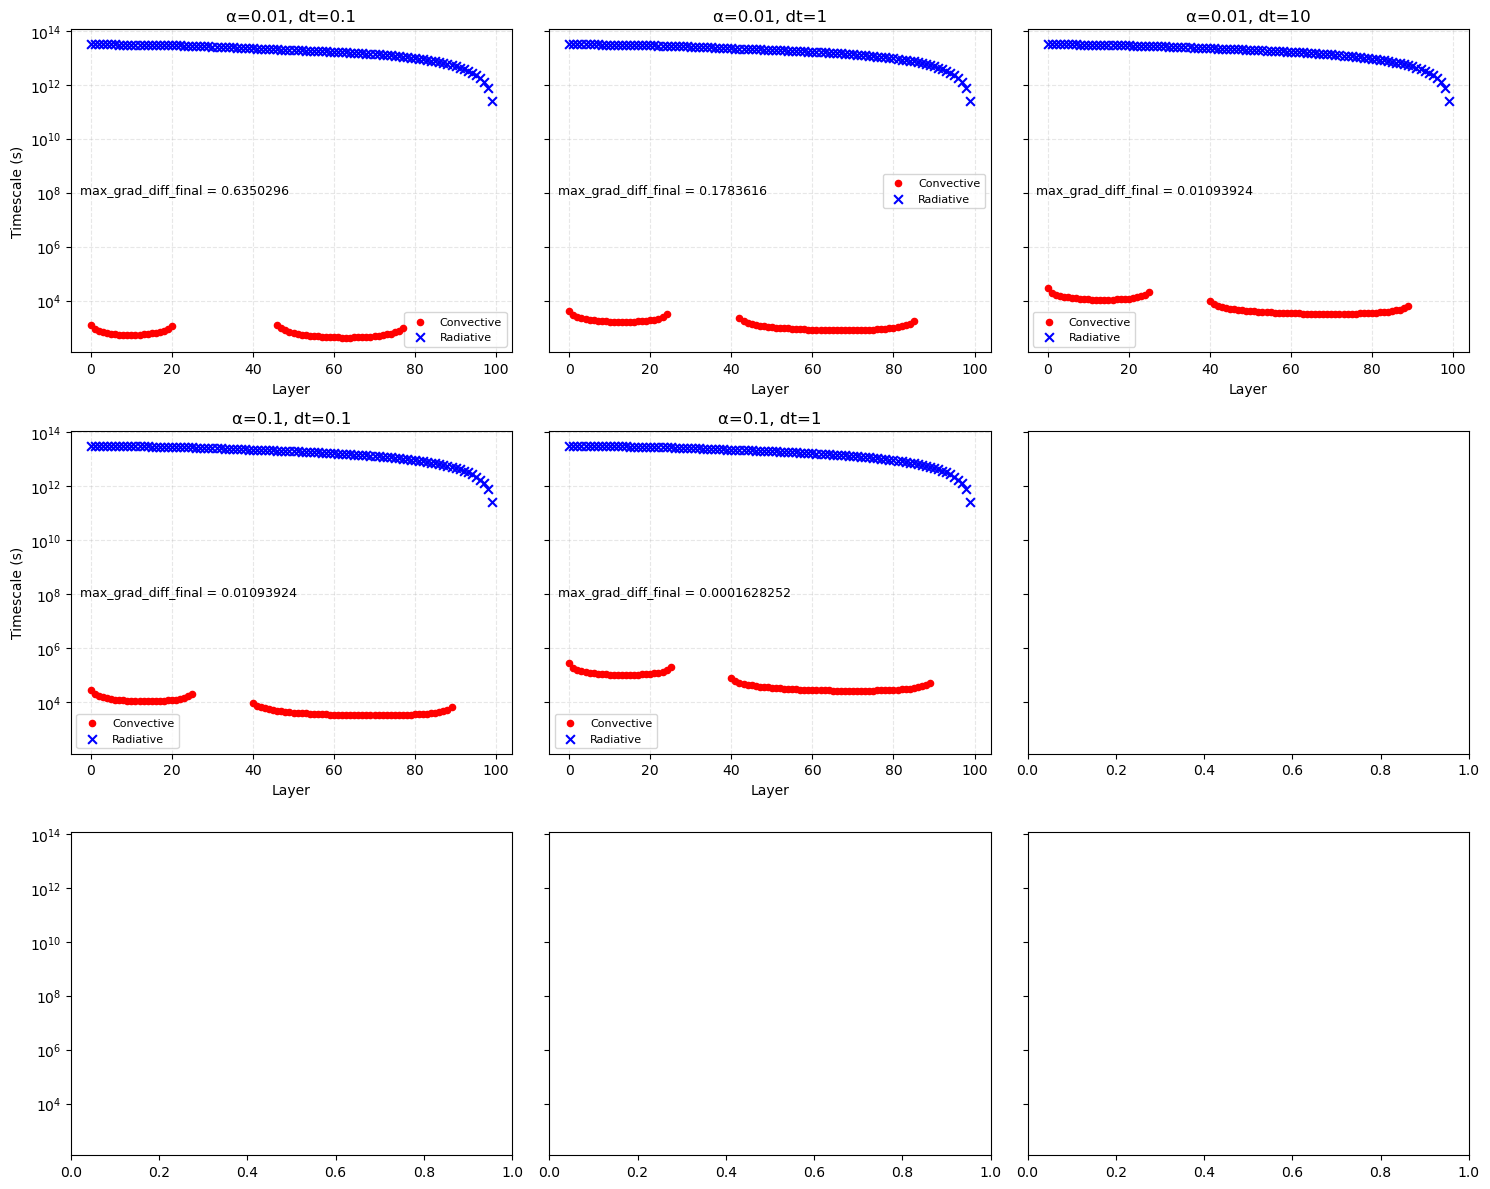

In [9]:
import json
import numpy as np
import matplotlib.pyplot as plt

# Parameters to plot
ALPHA_VALUES_PLOT = [0.01, 0.1, 1.0]
TIMESTEP_VALUES_PLOT = [0.1, 1, 10]

# Load data
with open('parameter_sweep_data_guillot.json', 'r') as f:
    data = json.load(f)

# Prepare figure
fig, axes = plt.subplots(3, 3, figsize=(15, 12), sharey=True)
fig.subplots_adjust(hspace=0.3, wspace=0.2)

for i, alpha in enumerate(ALPHA_VALUES_PLOT):
    for j, dt in enumerate(TIMESTEP_VALUES_PLOT):
        ax = axes[i, j]
        
        # Filter runs for this alpha and dt
        filtered_runs = [run for run in data['data'] 
                         if abs(run['alpha'] - alpha) < 1e-6 and abs(run['timestep'] - dt) < 1e-6]
        
        if len(filtered_runs) == 0:
            ax.set_title(f'α={alpha}, dt={dt}\n(No data)')
            ax.set_xlabel('Layer')
            if j == 0:
                ax.set_ylabel('Timescale (s)')
            continue
        
        run = filtered_runs[0]  # Assume only one run per combination
        
        n_layers = run['n_layers']
        layers = np.arange(n_layers)
        
        # Convective timescale
        t_conv = np.array([v if v is not None else np.nan for v in run.get('t_conv_final', [None]*n_layers)])
                # -----------------------------
        # Report null convective layers
        # -----------------------------
        null_conv_mask = ~np.isfinite(t_conv)

        if np.any(null_conv_mask):

            z_int = run.get('z_interfaces_km')
            P_int = run.get('P_final')

            # Guard against missing / null interface data
            if z_int is None or P_int is None:
                print(f"\nα={alpha}, dt={dt} | NULL convective layers, but z/P data missing")
                continue

            z_interfaces_km = np.asarray(z_int)
            P_interfaces = np.asarray(P_int)

            if z_interfaces_km.ndim != 1 or P_interfaces.ndim != 1:
                print(f"\nα={alpha}, dt={dt} | NULL convective layers, but z/P malformed")
                continue

            # Layer centers
            z_centers_km = 0.5 * (z_interfaces_km[:-1] + z_interfaces_km[1:])
            P_centers = 0.5 * (P_interfaces[:-1] + P_interfaces[1:])

            print(f"\nα={alpha}, dt={dt} | NULL convective timescale layers:")
            for idx in np.where(null_conv_mask)[0]:
                print(
                    f"  Layer {idx + 1:3d} | "
                    f"z = {z_centers_km[idx]:8.3f} km | "
                    f"P = {P_centers[idx]:.3e} Pa"
                )


        # Radiative timescale
        tau_rad = np.array([v if v is not None else np.nan for v in run.get('tau_rad_final', [None]*n_layers)])
        
        # Plot convective timescale - red dots
        finite_conv = np.isfinite(t_conv)
        ax.scatter(layers[finite_conv], t_conv[finite_conv], color='red', s=20, label='Convective', zorder=10)
        
        # Plot radiative timescale - blue crosses
        finite_rad = np.isfinite(tau_rad)
        ax.scatter(layers[finite_rad], tau_rad[finite_rad], color='blue', marker='x', s=40, label='Radiative', zorder=10)
        
        # Add max_grad_diff_final as text
        max_grad_diff = run.get('max_grad_diff_final', None)
        if max_grad_diff is not None:
            ax.text(0.02, 0.5, f"max_grad_diff_final = {max_grad_diff:.7g}", 
                    transform=ax.transAxes, fontsize=9, verticalalignment='center', color='black')
        
        ax.set_yscale('log')
        ax.set_xlabel('Layer')
        if j == 0:
            ax.set_ylabel('Timescale (s)')
        ax.set_title(f'α={alpha}, dt={dt}')

        ax.grid(True, linestyle='--', alpha=0.3)
        ax.legend(fontsize=8)

plt.tight_layout()
plt.show()



### Adiabat Overplot

α=0.01, dt=0.01 | Deviations (>1%):
  z = 22.50 km, P = 4.100e+07 Pa
  z = 27.50 km, P = 4.033e+07 Pa
  z = 32.50 km, P = 3.967e+07 Pa
  z = 37.50 km, P = 3.902e+07 Pa
  z = 42.50 km, P = 3.838e+07 Pa
  z = 47.50 km, P = 3.776e+07 Pa
  z = 52.50 km, P = 3.715e+07 Pa
  z = 57.50 km, P = 3.657e+07 Pa
  z = 62.50 km, P = 3.601e+07 Pa
  z = 67.50 km, P = 3.546e+07 Pa
  z = 72.50 km, P = 3.493e+07 Pa
  z = 77.50 km, P = 3.441e+07 Pa
  z = 82.50 km, P = 3.391e+07 Pa
  z = 87.50 km, P = 3.343e+07 Pa
  z = 92.50 km, P = 3.296e+07 Pa
  z = 97.50 km, P = 3.250e+07 Pa
  z = 102.50 km, P = 3.204e+07 Pa
  z = 107.50 km, P = 3.159e+07 Pa
  z = 112.50 km, P = 3.115e+07 Pa
  z = 117.50 km, P = 3.071e+07 Pa
  z = 122.50 km, P = 3.028e+07 Pa
  z = 127.50 km, P = 2.985e+07 Pa
  z = 132.50 km, P = 2.943e+07 Pa
  z = 137.50 km, P = 2.901e+07 Pa
  z = 142.50 km, P = 2.859e+07 Pa
  z = 147.50 km, P = 2.817e+07 Pa
  z = 152.50 km, P = 2.776e+07 Pa
  z = 157.50 km, P = 2.735e+07 Pa
  z = 162.50 km, P = 2.693e+

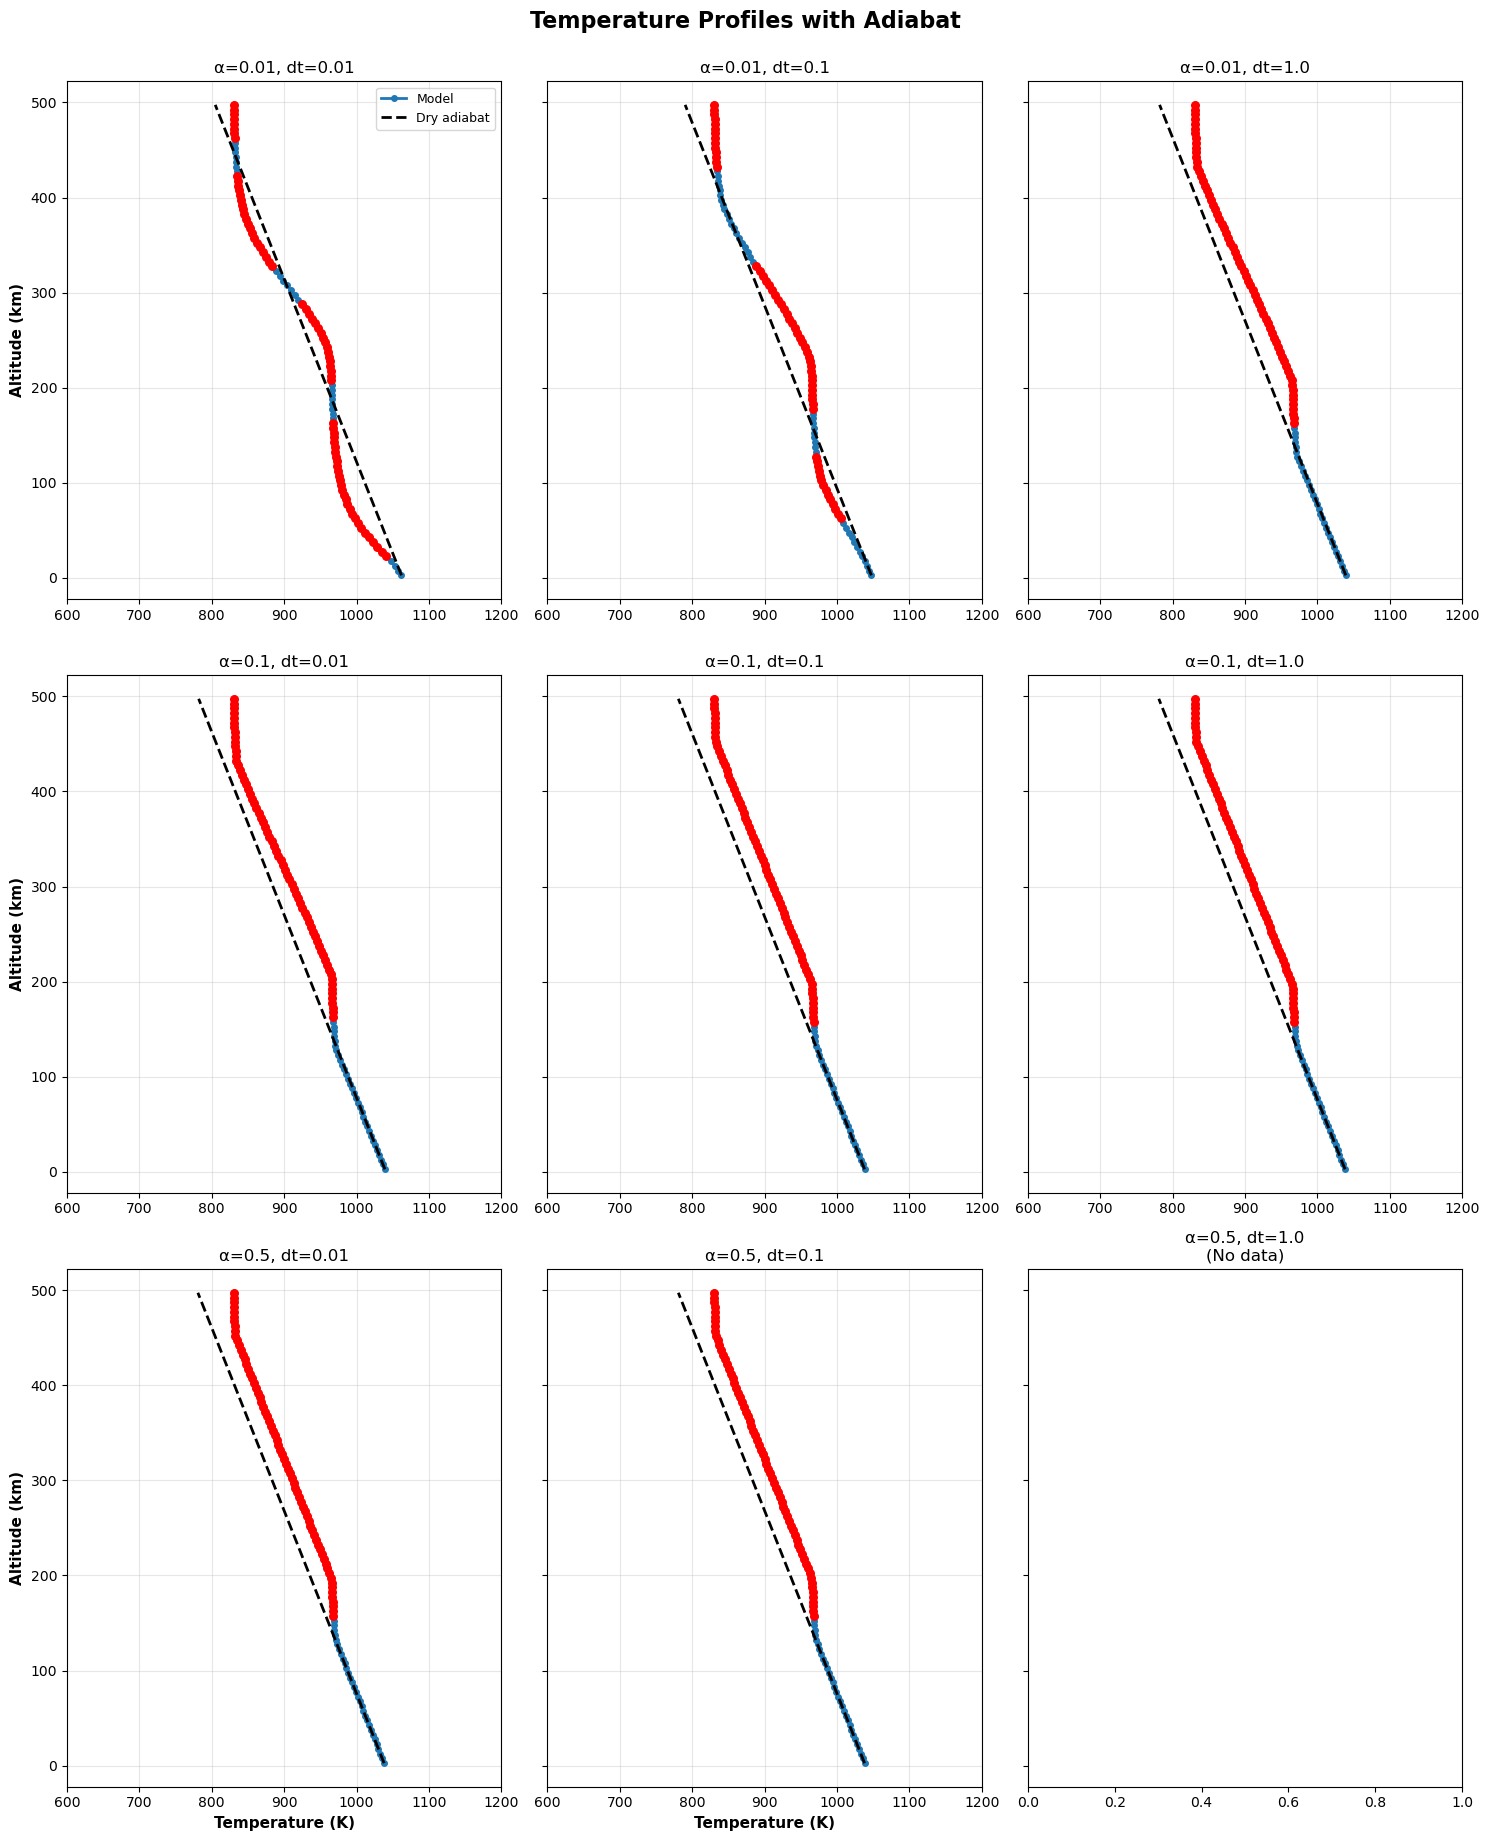

In [12]:
import json
import numpy as np
import matplotlib.pyplot as plt

# -----------------------------
# Parameters to plot
# -----------------------------
ALPHA_VALUES = [0.01, 0.1, 0.5]
DT_VALUES = [0.01, 0.1, 1.0]

# -----------------------------
# Load data
# -----------------------------
with open('parameter_sweep_data_guillot.json', 'r') as f:
    data = json.load(f)

# -----------------------------
# Set up figure
# -----------------------------
fig, axes = plt.subplots(
    nrows=len(ALPHA_VALUES),
    ncols=len(DT_VALUES),
    figsize=(15, 18),
    sharey=True
)

# -----------------------------
# Loop over alpha / dt
# -----------------------------
for i, alpha in enumerate(ALPHA_VALUES):
    for j, dt in enumerate(DT_VALUES):
        ax = axes[i, j]

        runs = [
            run for run in data['data']
            if run.get('T_final') is not None
            and run.get('z_interfaces_km') is not None
            and abs(run.get('alpha', -1) - alpha) < 1e-6
            and abs(run.get('timestep', -1) - dt) < 1e-6
        ]

        if len(runs) == 0:
            ax.set_title(f'α={alpha}, dt={dt}\n(No data)')
            continue

        run = runs[0]

        # -----------------------------
        # Layer-center quantities
        # -----------------------------
        T_interfaces = np.array(run['T_final'])
        z_interfaces_km = np.array(run['z_interfaces_km'])

        z_interfaces_m = z_interfaces_km * 1000.0

        T_centers = 0.5 * (T_interfaces[:-1] + T_interfaces[1:])
        z_centers = 0.5 * (z_interfaces_m[:-1] + z_interfaces_m[1:])

        # -----------------------------
        # Adiabat using stored N_ad
        # -----------------------------
        if 'N_ad' not in run:
            raise RuntimeError("N_ad not found in run data")

        Gamma = run['N_ad']  # K/m

        base_idx = np.argmin(z_centers)
        T0 = T_centers[base_idx]
        z0 = z_centers[base_idx]

        T_adiabat = T0 - Gamma * (z_centers - z0)
                # -----------------------------
        # Deviation from adiabat (>5%)
        # -----------------------------
        frac_dev = np.abs(T_centers - T_adiabat) / T_adiabat
        bad_mask = frac_dev > 0.01


        # -----------------------------
        # Plot
        # -----------------------------
        ax.plot(
            T_centers,
            z_centers / 1000.0,
            'o-',
            linewidth=2,
            markersize=4,
            label='Model'
        )

        ax.plot(
            T_adiabat,
            z_centers / 1000.0,
            '--',
            color='black',
            linewidth=2,
            label='Dry adiabat'
        )

        ax.set_title(f'α={alpha}, dt={dt}')
        ax.set_xlim(600, 1200)
        ax.grid(True, alpha=0.3)

        if i == len(ALPHA_VALUES) - 1:
            ax.set_xlabel('Temperature (K)', fontsize=11, fontweight='bold')

        if j == 0:
            ax.set_ylabel('Altitude (km)', fontsize=11, fontweight='bold')

        if i == 0 and j == 0:
            ax.legend(fontsize=9)

        if 'P_final' in run:
            P_interfaces = np.array(run['P_final'])
            P_centers = 0.5 * (P_interfaces[:-1] + P_interfaces[1:])

            # Plot deviation points (temperature vs altitude)
            ax.scatter(
                T_centers[bad_mask],
                z_centers[bad_mask] / 1000.0,
                color='red',
                s=30,
                zorder=5,
                label='>5% off adiabat' if (i == 0 and j == 0) else None
            )

            # Optional: print pressure + altitude for debugging
            print(
                f"α={alpha}, dt={dt} | Deviations (>1%):"
            )
            for zz, pp in zip(z_centers[bad_mask], P_centers[bad_mask]):
                print(f"  z = {zz/1000:.2f} km, P = {pp:.3e} Pa")


# -----------------------------
# Final layout
# -----------------------------
plt.tight_layout()
plt.suptitle(
    'Temperature Profiles with Adiabat',
    fontsize=16,
    fontweight='bold',
    y=1.02
)
plt.show()
